# AirBnB Dataset Prediction

Testing linear regression (and 1 other algorithm) for predicting price of an AirBnB listing based on various features such as amenities, location and other factors.

The dataset used is from https://insideairbnb.com/get-the-data/. Credits to author.

3 main cities will be chosen for comparison.

They are Singapore, Tokyo Japan, and London England.

**Stick to Japan Dataset as of now**

**What the Datset Columns Entail**

https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596

In [ ]:
# AIRBNB PRICE PREDICTION ANALYSIS
import os

cwd = os.getcwd()
print(cwd)

/content


In [ ]:
# move the Airbnb Dataset .gzip file to /content after downloading it at the website
import gzip
import shutil

# download the gzip file from the link above

compressed_name = 'listings.csv.gz' # what ever name you choose for the gzip file
file_name = 'listings.csv'

with gzip.open(compressed_name, 'rb') as f_in:
    with open(file_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

The name of the file will be *listings.csv*

# 1. Data Cleaning and Preprocessing
Clean the data and analyse the features for the most relevant data to be fed to the model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# For Bayesian tuning
!pip install -q scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real

# For XGBoost tuning and stacking:
!pip install -q xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge




# show the three rows
df = pd.read_csv('/content/listings.csv')
df.head(3)

id                          listing_url       scrape_id last_scraped  \
0  197677  https://www.airbnb.com/rooms/197677  20241230011552   2024-12-30   
1  776070  https://www.airbnb.com/rooms/776070  20241230011552   2024-12-30   
2  905944  https://www.airbnb.com/rooms/905944  20241230011552   2024-12-30   

        source                                               name  \
0  city scrape                          Oshiage Holiday Apartment   
1  city scrape                             Kero-kero house room 1   
2  city scrape  4F Spacious Apartment in Shinjuku / Shibuya Tokyo   

                                         description  \
0                                                NaN   
1  We have been in airbnb since 2011 and it has g...   
2  NEWLY RENOVATED property entirely for you & yo...   

                               neighborhood_overview  \
0                                                NaN   
1  We love Nishinippori because is nearer to Toky...   
2  Hatagaya is a great neighborhood located 4 min...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/38437056/d27f...   964081  ...   
1  https://a0.muscache.com/pictures/efd9f039-dbd2...   801494  ...   
2  https://a0.muscache.com/pictures/miso/Hosting-...  4847803  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.84                   4.56                4.80   
1                        4.98                   4.84                4.92   
2                        4.91                   4.78                4.78   

                                             license instant_bookable  \
0                                         M130003350                f   
1                                         M130000243                f   
2  Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...                t   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              1                                           0   
2                              8                                           8   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            1   
2                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              1.13  
1                                           0              1.79  
2                                           0              1.69  

[3 rows x 75 columns]

In [ ]:
# View the columns to see what's available in the dataset
print(df.columns)
print(len(df.columns))

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
# view what data types exists in the dataset
# brief overview (uncomment to see)
# df.dtypes

# detailed overview
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21058 entries, 0 to 21057
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21058 non-null  int64  
 1   listing_url                                   21058 non-null  object 
 2   scrape_id                                     21058 non-null  int64  
 3   last_scraped                                  21058 non-null  object 
 4   source                                        21058 non-null  object 
 5   name                                          21058 non-null  object 
 6   description                                   20716 non-null  object 
 7   neighborhood_overview                         12731 non-null  object 
 8   picture_url                                   21058 non-null  object 
 9   host_id                                       21058 non-null 

In [ ]:
# How many rows are there before cleaning
df.shape[0]

21058

In [ ]:
# Determine if there are null values within the dataset
# isnull.().sum(axis=0) does not show everything
# df.isnull().sum(axis=0)

# rather than check everything, just view what columns have null values
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Filter only columns with nulls
print(null_counts)

description                       342
neighborhood_overview            8327
host_name                           4
host_since                          4
host_location                    5901
host_about                       6299
host_response_time                480
host_response_rate                480
host_acceptance_rate              351
host_is_superhost                1359
host_thumbnail_url                  4
host_picture_url                    4
host_neighbourhood              14314
host_listings_count                 4
host_total_listings_count           4
host_verifications                  4
host_has_profile_pic                4
host_identity_verified              4
neighbourhood                    8327
neighbourhood_group_cleansed    21058
bathrooms                        2227
bathrooms_text                     46
bedrooms                          264
beds                             2228
price                            2259
minimum_minimum_nights             19
maximum_mini

We need to drop any unnecessary information that is not relevant to price calculation.

We can start first with any irrelevant data that has no impact on price calculation whatsoever.

We want to ensure these columns remain :

**Property & Listing Attributes**

* property_type (Different types have different pricing, e.g., "Apartment" vs. "Villa")
* room_type (Entire home/apt vs. private room affects price)
* accommodates (More guests usually means higher price)
* bathrooms_text (Number of bathrooms affects price)
* bedrooms (More bedrooms typically increase price)
* beds (More beds can increase listing value)
* amenities (Luxury amenities like pools, WiFi, and AC may increase price)


**Location**
* latitude / longitude (Can be used to extract geo-based price trends)

**Host Information** (If Significant)
* host_is_superhost (Superhosts may charge higher prices)
* host_listings_count / host_total_listings_count (Professional hosts vs. casual hosts may price differently)
* host_identity_verified (Could be a trust factor affecting pricing)
Availability & Minimum Nights
* minimum_nights (Longer stays could impact price)
* availability_30, availability_60, availability_90, availability_365 (More * * availability may suggest demand or pricing trends)

**Reviews & Ratings**
* number_of_reviews (More reviews may indicate demand)
* review_scores_rating (Higher ratings may allow higher prices)
* reviews_per_month (Shows frequency of bookings, indicating demand)

Edit as necessary*

In [ ]:
## List of columns to drop
#drop_columns = [
#    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
#    'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
#    'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'host_neighbourhood',
#    'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic',
#    'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
#    'neighbourhood', 'neighborhood_overview', 'neighbourhood_group_cleansed', 'license', 'picture_url', 'host_id',
#    'maximum_nights_avg_ntm', 'has_availability', 'calendar_last_scraped',
#    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
#    'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
#    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
#]

# double check this
# columns to consider scrutizing
# superhost? description? (no desc, less lightly to be bought)

# Drop columns that are not useful for price prediction
drop_columns = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
    'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'host_neighbourhood',
    'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic',
    'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
    'neighbourhood', 'neighborhood_overview', 'neighbourhood_group_cleansed', 'license', 'picture_url', 'host_id',
    'maximum_nights_avg_ntm', 'has_availability', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
    'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'name', 'description'
]
# Drop columns
df_cleaned = df.drop(columns=drop_columns)

In [ ]:
# this is the new cleaned dataset
df_cleaned.head()

host_response_time host_response_rate host_acceptance_rate  \
0        within a day               100%                  93%   
1      within an hour               100%                 100%   
2      within an hour               100%                 100%   
3  within a few hours               100%                 100%   
4      within an hour               100%                  92%   

  host_is_superhost host_identity_verified neighbourhood_cleansed  latitude  \
0                 t                      t              Sumida Ku  35.71707   
1                 t                      t                Kita Ku  35.73844   
2                 t                      f             Shibuya Ku  35.67878   
3                 t                      t            Setagaya Ku  35.65800   
4                 t                      t              Adachi Ku  35.74363   

   longitude         property_type        room_type  ...  number_of_reviews  \
0  139.82608    Entire rental unit  Entire home/apt  ...                183   
1  139.76917  Private room in home     Private room  ...                264   
2  139.67847    Entire rental unit  Entire home/apt  ...                242   
3  139.67134  Private room in home     Private room  ...                271   
4  139.79852  Private room in home     Private room  ...                135   

   review_scores_rating review_scores_accuracy  review_scores_cleanliness  \
0                  4.78                   4.75                       4.91   
1                  4.98                   4.97                       4.92   
2                  4.80                   4.81                       4.79   
3                  4.95                   4.94                       4.84   
4                  4.80                   4.89                       4.79   

   review_scores_checkin review_scores_communication review_scores_location  \
0                   4.85                        4.84                   4.56   
1                   4.98                        4.98                   4.84   
2                   4.87                        4.91                   4.78   
3                   4.94                        4.98                   4.92   
4                   4.94                        4.92                   4.74   

   review_scores_value  instant_bookable  reviews_per_month  
0                 4.80                 f               1.13  
1                 4.92                 f               1.79  
2                 4.78                 t               1.69  
3                 4.90                 f               1.90  
4                 4.82                 f               0.97  

[5 rows x 38 columns]

In [ ]:
# check for remaining missing values in the columns
df_cleaned.isnull().sum()

host_response_time              480
host_response_rate              480
host_acceptance_rate            351
host_is_superhost              1359
host_identity_verified            4
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                      2227
bathrooms_text                   46
bedrooms                        264
beds                           2228
amenities                         0
price                          2259
minimum_nights                    0
maximum_nights                    0
minimum_minimum_nights           19
maximum_minimum_nights           19
minimum_maximum_nights           19
maximum_maximum_nights           19
minimum_nights_avg_ntm           19
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating           2883
review_scores_accuracy         2886
review_scores_cleanliness      2886
review_scores_checkin          2885
review_scores_communication    2886
review_scores_location         2886
review_scores_value            2886
instant_bookable                  0
reviews_per_month              2883
dtype: int64

In [ ]:
# Drop the rows with empty fields
# some empty is fine, but need to consider the following : price, bedrooms, bathroom
#df_cleaned = df_cleaned.dropna()

df_cleaned = df.drop(columns=drop_columns)
print("Shape after dropping irrelevant columns:", df_cleaned.shape)


Shape after dropping irrelevant columns: (21058, 38)


In [ ]:
# Drop rows with any missing values (you may change this to imputation if desired)
df_cleaned = df_cleaned.dropna()
print("Shape after dropping rows with missing values:", df_cleaned.shape)
print("Remaining null counts:\n", df_cleaned.isnull().sum())

Shape after dropping rows with missing values: (14988, 38)
Remaining null counts:
 host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bathrooms_text                 0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
minimum_minimum_nights         0
maximum_minimum_nights         0
minimum_maximum_nights         0
maximum_maximum_nights         0
minimum_nights_avg_ntm         0
availability_30                0
availability_60                0
availability_90                0
availability_365          

In [ ]:
# check how much we are left with and ensure that there are no more field empty within the dataset
print(df_cleaned.isnull().sum())
print(df_cleaned.shape[0])

host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bathrooms_text                 0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
minimum_minimum_nights         0
maximum_minimum_nights         0
minimum_maximum_nights         0
maximum_maximum_nights         0
minimum_nights_avg_ntm         0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
review_scores_rating           0
review_sco

In [ ]:
# view how many unique object exists in each column
include = ['object', 'float', 'int']
df_cleaned.describe(include=include)

host_response_time host_response_rate host_acceptance_rate  \
count               14988              14988                14988   
unique                  4                 34                   62   
top        within an hour               100%                 100%   
freq                14266              13663                 8210   
mean                  NaN                NaN                  NaN   
std                   NaN                NaN                  NaN   
min                   NaN                NaN                  NaN   
25%                   NaN                NaN                  NaN   
50%                   NaN                NaN                  NaN   
75%                   NaN                NaN                  NaN   
max                   NaN                NaN                  NaN   

       host_is_superhost host_identity_verified neighbourhood_cleansed  \
count              14988                  14988                  14988   
unique                 2                      2                     48   
top                    f                      t            Shinjuku Ku   
freq                8273                  14456                   2754   
mean                 NaN                    NaN                    NaN   
std                  NaN                    NaN                    NaN   
min                  NaN                    NaN                    NaN   
25%                  NaN                    NaN                    NaN   
50%                  NaN                    NaN                    NaN   
75%                  NaN                    NaN                    NaN   
max                  NaN                    NaN                    NaN   

            latitude     longitude       property_type        room_type  ...  \
count   14988.000000  14988.000000               14988            14988  ...   
unique           NaN           NaN                  57                4  ...   
top              NaN           NaN  Entire rental unit  Entire home/apt  ...   
freq             NaN           NaN                9450            12764  ...   
mean       35.698388    139.736506                 NaN              NaN  ...   
std         0.042775      0.072922                 NaN              NaN  ...   
min        35.520940    139.081322                 NaN              NaN  ...   
25%        35.687278    139.699098                 NaN              NaN  ...   
50%        35.704152    139.727605                 NaN              NaN  ...   
75%        35.724040    139.792240                 NaN              NaN  ...   
max        35.840764    139.914020                 NaN              NaN  ...   

        number_of_reviews  review_scores_rating review_scores_accuracy  \
count        14988.000000          14988.000000           14988.000000   
unique                NaN                   NaN                    NaN   
top                   NaN                   NaN                    NaN   
freq                  NaN                   NaN                    NaN   
mean            42.032693              4.709331               4.750401   
std             68.508870              0.341878               0.317270   
min              1.000000              1.000000               0.000000   
25%              7.000000              4.600000               4.670000   
50%             20.000000              4.790000               4.830000   
75%             50.000000              4.930000               4.940000   
max           3092.000000              5.000000               5.000000   

        review_scores_cleanliness  review_scores_checkin  \
count                14988.000000           14988.000000   
unique                        NaN                    NaN   
top                           NaN                    NaN   
freq                          NaN                    NaN   
mean                     4.694550               4.771120   
std                      0.370476               0.306719   
min                

Since we are predicting the price, we have to convert the data type of the price column to a readable one

In [ ]:
# parse the price column into readable float
#df_cleaned['price'] = df_cleaned['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert the price column to float (remove $ and commas)
df_cleaned['price'] = df_cleaned['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
print("Sample of price column:")
print(df_cleaned['price'].head())

Sample of price column:
0    13000.0
1     9474.0
2    39363.0
3    26571.0
4    10571.0
Name: price, dtype: float64


In [ ]:
df_cleaned.price.head()

0    13000.0
1     9474.0
2    39363.0
3    26571.0
4    10571.0
Name: price, dtype: float64

**Feature Engineering**

As a huge portion of the data is categorical in nature, we can use one hot encoding (https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) to cateorize if an entry has *x* or *y* property or none at all.

The next sections will be dealing with feature egineering with columns that are categorical so as to allow the model to better understand the relationship of each feature and how it correlates to the prediction of the price.



## 1.1 Property & Physical Attributes

The next few sections will be dedicated for feature engineering based on features describing the features of the physical atributes of the AirBnB listings.

### 1.1.1 Cleaning of Physical Attributes Features

Each features must be scrutinized and cleaned to be fitted into the model. Amenities, room types, bathroom and bedrooms and then price.

**Amenities**

We will first start of with amenities as an example.

We need to one-hot encoding for all the amenities listed within the given amenity column.

The format of the amenities is listed as an array i.e.

[ "Hangers", "Wi-Fi", ... "etc" ]

In [ ]:
# need to start fitting the data for a correlation map
# get the unique values for all the amenities
# and encode them for fitting
import ast

df_cleaned['amenities'] = df_cleaned['amenities'].apply(ast.literal_eval)

# Get all unique amenities
unique_amenities = set()
df_cleaned['amenities'].apply(lambda x: unique_amenities.update(x))  # Flatten all amenities

# Convert to sorted list for readability
unique_amenities = sorted(unique_amenities)

# Display all unique amenities
print(unique_amenities)

[' SHARP refrigerator', '"MAROA" Organic Essential Oil Body Soap body soap', '"MAROA" Organic Essential Oil Shampoo shampoo', '"MAROA" Organic Essential Oil Treatment conditioner', '&honey（アンドハニー） conditioner', '&honey（アンドハニー） shampoo', '*リンスインシャンプー\u3000*Two-in-one shampoo shampoo', '*洗面所に冷蔵庫とドライヤー、受付手前に電子レンジ、電気ポットがございます。すべて共用です。また、無料のインスタントコーヒーやお茶をご用意しております。\u3000 *Refrigerator and hair dryers in the washroom, microwave and electric pot in front of the reception are all shared. Also, instant coffee and green tea in front of the reception are free. refrigerator', '1.2高冰箱 refrigerator', '100 inch HDTV with Amazon Prime Video, Apple TV, Chromecast, Hulu, Netflix, DVD player', '100 inch HDTV with Amazon Prime Video, Apple TV, Disney+, Fire TV, Hulu, Netflix', '100 inch HDTV with Netflix', '100 inch TV with Amazon Prime Video, Apple TV, Disney+, Fire TV, Hulu, Netflix', '100 inch TV with Amazon Prime Video, Apple TV, Hulu, Netflix, DVD player', '100 inch TV with Netflix', '12 inch TV', '1

The sheer number of unique amenity values means that one-hot encoding will result in too much columns for amenities, resulting in overfitting.

To fix this, we need to categorise the amenities into broad categories to ensure reliable prediction.

In [ ]:
# # Define categories with variations & Japanese translations
# wifi_amenities = {"wifi", "wi-fi", "無線lan", "ワイヤレスインターネット"}
# kitchen_amenities = {"kitchen", "microwave", "refrigerator", "stove", "oven", "調理場", "電子レンジ", "冷蔵庫", "コンロ", "オーブン"}
# parking_amenities = {"free parking", "paid parking", "駐車場", "無料駐車場", "有料駐車場"}
# pool_amenities = {"pool", "swimming pool", "hot tub", "浴槽", "プール", "温泉"}
# air_conditioning_amenities = {"air conditioning", "heating", "ceiling fan", "エアコン", "冷房", "暖房", "扇風機"}
# security_amenities = {"smoke alarm", "carbon monoxide alarm", "first aid kit", "fire extinguisher", "防火設備", "火災警報器", "一酸化炭素警報", "救急キット"}
# laundry_amenities = {"washer", "dryer", "laundromat", "iron", "洗濯機", "乾燥機", "ランドリー", "アイロン"}
# entertainment_amenities = {"tv", "sound system", "streaming services", "テレビ", "スピーカー", "ストリーミング"}

# # Function for case-insensitive & flexible matching (check if this works ** , can convert amenti to lower caps to standardize)
# def has_category(amenities, category):
#     return int(any(any(keyword in amenity for keyword in category) for amenity in amenities))

# # Each value will be checked according to the dictionaries, if any of string matches, place the category as 1
# # otherwise, it will be placed as 0
# # Apply function to dataset
# df_cleaned['has_wifi'] = df_cleaned['amenities'].apply(lambda x: has_category(x, wifi_amenities))
# df_cleaned['has_kitchen'] = df_cleaned['amenities'].apply(lambda x: has_category(x, kitchen_amenities))
# df_cleaned['has_parking'] = df_cleaned['amenities'].apply(lambda x: has_category(x, parking_amenities))
# df_cleaned['has_pool'] = df_cleaned['amenities'].apply(lambda x: has_category(x, pool_amenities))
# df_cleaned['has_air_conditioning'] = df_cleaned['amenities'].apply(lambda x: has_category(x, air_conditioning_amenities))
# df_cleaned['has_security'] = df_cleaned['amenities'].apply(lambda x: has_category(x, security_amenities))
# df_cleaned['has_laundry'] = df_cleaned['amenities'].apply(lambda x: has_category(x, laundry_amenities))
# df_cleaned['has_entertainment'] = df_cleaned['amenities'].apply(lambda x: has_category(x, entertainment_amenities))

# Define categorized amenities

wifi_amenities = {"Wifi", "Wi-Fi", "Ethernet connection", "無線lan", "ワイヤレスインターネット"}
kitchen_amenities = {"Kitchen", "Microwave", "Refrigerator", "Stove", "Oven", "BBQ grill", "Coffee maker", "Dining table"}
parking_amenities = {"Parking", "Garage", "EV charger", "free parking", "paid parking", "carport"}
pool_amenities = {"Pool", "Swimming pool", "Hot tub"}
air_conditioning_amenities = {"Air conditioning", "Heating", "Ceiling fan", "Indoor Fireplace"}
security_amenities = {"Smoke alarm", "Fire extinguisher", "Carbon monoxide alarm"}
laundry_amenities = {"Washer", "Dryer", "Iron", "Clothing storage", "Housekeeping"}
bathroom_amenities = {"Bathtub", "Bidet", "Hot water", "Body Soap", "Shampoo", "Conditioner"}
entertainment_amenities = {"TV", "HDTV", "Sound System", "Game console", "Streaming services"}
fitness_amenities = {"Exercise equipment", "Gym"}
child_friendly_amenities = {"Baby Monitor", "Baby bath", "High chair", "Crib", "Children’s books and toys"}
outdoor_amenities = {"Backyard", "BBQ grill"}
elevator_amenities = {"Elevator"}

# Combine all categories into one dictionary
all_amenities = {
    "has_wifi": wifi_amenities,
    "has_kitchen": kitchen_amenities,
    "has_parking": parking_amenities,
    "has_pool": pool_amenities,
    "has_air_conditioning": air_conditioning_amenities,
    "has_security": security_amenities,
    "has_laundry": laundry_amenities,
    "has_bathroom": bathroom_amenities,
    "has_entertainment": entertainment_amenities,
    "has_fitness": fitness_amenities,
    "has_child_friendly": child_friendly_amenities,
    "has_outdoor": outdoor_amenities,
    "has_elevator": elevator_amenities,
}

# Convert amenity strings into lists
df_cleaned['amenities'] = df_cleaned['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Apply category checks: True if any of the category amenities are in the listing
for column, category_set in all_amenities.items():
    df_cleaned[column] = df_cleaned['amenities'].apply(lambda x: any(item in category_set for item in x) if isinstance(x, list) else False)

# Also create columns for each **individual** amenity
for category_set in all_amenities.values():
    for amenity in category_set:
        col_name = f"has_{amenity.lower().replace(' ', '_')}"  # Normalize column name
        df_cleaned[col_name] = df_cleaned['amenities'].apply(lambda x: amenity in x if isinstance(x, list) else False)


# Create binary features for each amenity category
for col_name, amenity_set in all_amenities.items():
    df_cleaned[col_name] = df_cleaned['amenities'].apply(lambda x: any(item in amenity_set for item in x) if isinstance(x, list) else False)

# Also create individual amenity features (this may lead to many columns)
for category_set in all_amenities.values():
    for amenity in category_set:
        col_name = f"has_{amenity.lower().replace(' ', '_')}"
        df_cleaned[col_name] = df_cleaned['amenities'].apply(lambda x: amenity in x if isinstance(x, list) else False)

print("Columns after processing amenities:")
print(df_cleaned.columns.tolist())

# Drop amenity columns that are constant (all True or all False)
for amenity in [col for col in df_cleaned.columns if col.startswith('has_')]:
    if df_cleaned[amenity].sum() == 0 or df_cleaned[amenity].sum() == df_cleaned.shape[0]:
        df_cleaned = df_cleaned.drop(columns=[amenity])
        print("Dropping constant column:", amenity)

print(df_cleaned.columns)

Columns after processing amenities:
['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'reviews_per_month', 'has_wifi', 'has_kitchen', 'has_parking', 'has_pool', 'has_air_conditioning', 'has_security', 'has_laundry', 'has_bathroom', 'has_entertainment', 'has_fitness', 'has_child_friendly', 'has_o

Some of the amenity classification has 0 listings, rendering it moot, so just drop them.

Should drop them if all listings have said amenity, as it would be meaningless to classify.

In [ ]:
# check how many listings has
for amenity in df_cleaned.columns:
    if amenity.startswith('has_'):
        print(f"{amenity}: {df_cleaned[amenity].sum()} listings have this")
        if (df_cleaned[amenity].sum() == 0 or df_cleaned[amenity].sum() == df_cleaned.shape[0]):
            df_cleaned = df_cleaned.drop(columns=[amenity])
            print(f"Dropping {amenity}")


has_wifi: 13666 listings have this
has_kitchen: 12892 listings have this
has_pool: 5 listings have this
has_air_conditioning: 12733 listings have this
has_security: 14635 listings have this
has_laundry: 13431 listings have this
has_bathroom: 14533 listings have this
has_entertainment: 8503 listings have this
has_fitness: 132 listings have this
has_child_friendly: 1109 listings have this
has_outdoor: 347 listings have this
has_elevator: 4935 listings have this
has_ethernet_connection: 2176 listings have this
has_refrigerator: 12481 listings have this
has_bbq_grill: 98 listings have this
has_microwave: 13096 listings have this
has_stove: 5136 listings have this
has_coffee_maker: 925 listings have this
has_oven: 1179 listings have this
has_dining_table: 5701 listings have this
has_ev_charger: 48 listings have this
has_hot_tub: 680 listings have this
has_ceiling_fan: 255 listings have this
has_heating: 11432 listings have this
has_carbon_monoxide_alarm: 7130 listings have this
has_fire_ext

In [ ]:
df_cleaned.columns.tolist()

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'has_wifi',
 'has_kitchen',
 'has_pool',
 'has_air_conditioning',
 'has_security',
 'has_laundry',
 'has_bathroom',
 'has_entertainment',
 'has_fitness',
 'has_child_friendly',
 'has_outd

Feel free to add/delete/edit the amenity categories accordingly.

The key idea is to single out recurring patterns to categorise them.

If there is a valid use case for the categorisation i.e. splitting kitchen into *has_fridge* and *has_oven* , or *has_netflix* and/or other similar use cases.

In [ ]:
# df.drop(columns=['amenities'], inplace = True) # Drop the amenities column if necessary
df_cleaned.head()

host_response_time host_response_rate host_acceptance_rate  \
0        within a day               100%                  93%   
1      within an hour               100%                 100%   
2      within an hour               100%                 100%   
3  within a few hours               100%                 100%   
4      within an hour               100%                  92%   

  host_is_superhost host_identity_verified neighbourhood_cleansed  latitude  \
0                 t                      t              Sumida Ku  35.71707   
1                 t                      t                Kita Ku  35.73844   
2                 t                      f             Shibuya Ku  35.67878   
3                 t                      t            Setagaya Ku  35.65800   
4                 t                      t              Adachi Ku  35.74363   

   longitude         property_type        room_type  ...  has_game_console  \
0  139.82608    Entire rental unit  Entire home/apt  ...             False   
1  139.76917  Private room in home     Private room  ...             False   
2  139.67847    Entire rental unit  Entire home/apt  ...             False   
3  139.67134  Private room in home     Private room  ...             False   
4  139.79852  Private room in home     Private room  ...             False   

   has_tv has_hdtv  has_gym  has_exercise_equipment  \
0    True    False    False                   False   
1   False    False    False                   False   
2    True    False    False                   False   
3   False    False    False                   False   
4    True    False    False                   False   

  has_children’s_books_and_toys  has_crib  has_high_chair  has_baby_bath  \
0                         False     False           False          False   
1                         False     False           False          False   
2                         False     False           False          False   
3                         False     False           False          False   
4                          True     False           False          False   

   has_backyard  
0         False  
1         False  
2         False  
3         False  
4         False  

[5 rows x 84 columns]

Now we have the other unique values to process. This includes :

* property_type
* room_type
* bathrooms
* bathrooms_type
* bedrooms
* bedrooms_type
* accomodates

Other variables can be accounted for being used as factors, the aforementioned should be prioritised


**Room Type / Property Type**

Next will be the *room_type* and *property_type* of each listing.


In [ ]:
# Each value listed is shown to be either shared or private.
# We can also categorise the property type based on ....

df_cleaned['property_type'].unique()

array(['Entire rental unit', 'Private room in home', 'Entire home',
       'Shared room in rental unit', 'Private room in rental unit',
       'Private room in condo', 'Entire condo', 'Private room in villa',
       'Hut', 'Entire loft', 'Private room in serviced apartment',
       'Tiny home', 'Entire guest suite', 'Entire villa',
       'Entire townhouse', 'Room in aparthotel', 'Shared room in home',
       'Private room in townhouse', 'Private room in religious building',
       'Entire guesthouse', 'Entire cabin', 'Private room in guesthouse',
       'Entire bungalow', 'Room in boutique hotel',
       'Private room in cabin', 'Private room in hostel', 'Room in hotel',
       'Room in hostel', 'Private room',
       'Private room in bed and breakfast',
       'Shared room in bed and breakfast', 'Private room in hut',
       'Entire serviced apartment', 'Private room in ryokan',
       'Shared room in hostel', 'Shared room in hut',
       'Room in serviced apartment', 'Private room i

In [ ]:
df_cleaned['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

Between the 2, it better to use room_type as a better baseline comparison to avoid complicating these features.

We can drop *property_type* as a result, and just one-hot encode *room_type*.

In [ ]:
# get rid of property type
df_cleaned = df_cleaned.drop(columns=['property_type'])

In [ ]:
# and one-hot encode the room types
df_cleaned = pd.get_dummies(df_cleaned, columns=['room_type'], prefix=['room_type'])  # One-hot encode room_type
df_cleaned.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'has_wifi', 'has_kitchen', 'has_pool', 'has_air_conditioning',
       'has_security', 'has_laundry', 'has_bathroom', 'has_entertainment',
       'has_fitness', 'has_

In [ ]:
df_cleaned.head(3)

host_response_time host_response_rate host_acceptance_rate  \
0       within a day               100%                  93%   
1     within an hour               100%                 100%   
2     within an hour               100%                 100%   

  host_is_superhost host_identity_verified neighbourhood_cleansed  latitude  \
0                 t                      t              Sumida Ku  35.71707   
1                 t                      t                Kita Ku  35.73844   
2                 t                      f             Shibuya Ku  35.67878   

   longitude  accommodates  bathrooms  ... has_exercise_equipment  \
0  139.82608             2        1.0  ...                  False   
1  139.76917             1        1.0  ...                  False   
2  139.67847             6        1.5  ...                  False   

   has_children’s_books_and_toys  has_crib has_high_chair  has_baby_bath  \
0                          False     False          False          False   
1                          False     False          False          False   
2                          False     False          False          False   

   has_backyard  room_type_Entire home/apt  room_type_Hotel room  \
0         False                       True                 False   
1         False                      False                 False   
2         False                       True                 False   

   room_type_Private room  room_type_Shared room  
0                   False                  False  
1                    True                  False  
2                   False                  False  

[3 rows x 86 columns]

**Bathrooms / Bathrooms Text**

Next will be the bathroom features *bathrooms* and *bathroom_text*. Similar to room and property features, we are going to focus on the *bathrooms* value only as it is already standardized.

The unique values will still be shown in case anyone wants to make use of the unique values in *bathroom_text*.

In [ ]:
print("Unique numbers of bathrooms:\n")
print(df_cleaned.bathrooms.unique())
print(df_cleaned.bathrooms.value_counts())
print("\nUnique bathroom types in bathroom_text:\n")
print(df_cleaned.bathrooms_text.unique())
print(df_cleaned.bathrooms_text.value_counts())

Unique numbers of bathrooms:

[ 1.   1.5  0.5  2.   2.5  3.   3.5  6.   5.5  4.   7.   0.   5.  17.
  8.5 11.   4.5 10.  10.5]
bathrooms
1.0     11823
1.5      1561
2.0       896
0.5       226
3.0       163
2.5        86
0.0        81
4.0        56
3.5        29
5.0        17
6.0        16
10.0        9
5.5         8
7.0         7
4.5         4
8.5         2
11.0        2
17.0        1
10.5        1
Name: count, dtype: int64

Unique bathroom types in bathroom_text:

['1 bath' '1 shared bath' '1.5 baths' 'Half-bath' '2 baths' '2.5 baths'
 '2 shared baths' 'Private half-bath' '1 private bath' '2.5 shared baths'
 '1.5 shared baths' 'Shared half-bath' '3 baths' '3.5 baths' '6 baths'
 '5.5 baths' '4 shared baths' '7 shared baths' '6 shared baths' '4 baths'
 '0 shared baths' '7 baths' '5 shared baths' '17 shared baths'
 '3 shared baths' '0 baths' '5 baths' '3.5 shared baths' '8.5 baths'
 '11 baths' '4.5 baths' '10 baths' '5.5 shared baths' '10 shared baths'
 '11 shared baths' '10.5 shared ba

In [ ]:
# drop bathroom_text for now, only normalise bathrooms if need to
df_cleaned = df_cleaned.drop(columns=['bathrooms_text'])
df_cleaned.head(3)

host_response_time host_response_rate host_acceptance_rate  \
0       within a day               100%                  93%   
1     within an hour               100%                 100%   
2     within an hour               100%                 100%   

  host_is_superhost host_identity_verified neighbourhood_cleansed  latitude  \
0                 t                      t              Sumida Ku  35.71707   
1                 t                      t                Kita Ku  35.73844   
2                 t                      f             Shibuya Ku  35.67878   

   longitude  accommodates  bathrooms  ...  has_exercise_equipment  \
0  139.82608             2        1.0  ...                   False   
1  139.76917             1        1.0  ...                   False   
2  139.67847             6        1.5  ...                   False   

   has_children’s_books_and_toys has_crib  has_high_chair  has_baby_bath  \
0                          False    False           False          False   
1                          False    False           False          False   
2                          False    False           False          False   

   has_backyard  room_type_Entire home/apt  room_type_Hotel room  \
0         False                       True                 False   
1         False                      False                 False   
2         False                       True                 False   

   room_type_Private room  room_type_Shared room  
0                   False                  False  
1                    True                  False  
2                   False                  False  

[3 rows x 85 columns]

**Bedrooms / Beds**

Any AirBnB should have beds and bedrooms, but apparently there might be some with 0 beds and bedrooms.

There's no need to clean these values at the moment, so we can leave them be.

In [ ]:
print("Unique count of bedrooms:\n")
print(df_cleaned.bedrooms.unique())
print(df_cleaned.bedrooms.value_counts())
print("\nUnique count of beds:\n")
print(df_cleaned.beds.unique())
print(df_cleaned.beds.value_counts())

# Remove unrealistic listings: limit bedrooms and beds to <= 10
df_cleaned = df_cleaned[df_cleaned['bedrooms'] <= 10]
df_cleaned = df_cleaned[df_cleaned['beds'] <= 10]

print("Accommodates unique values:", df_cleaned.accommodates.unique())
print("Accommodates counts:\n", df_cleaned.accommodates.value_counts())

Unique count of bedrooms:

[ 1.  2.  0.  4.  6.  3.  5.  9. 36. 50.  8. 30. 35.  7. 10. 21. 12.]
bedrooms
1.0     9797
2.0     2423
3.0     1160
0.0      935
4.0      485
5.0      113
6.0       41
7.0       13
8.0        9
10.0       3
12.0       2
9.0        2
30.0       1
35.0       1
50.0       1
21.0       1
36.0       1
Name: count, dtype: int64

Unique count of beds:

[ 2.  1.  4.  0.  8.  3.  5.  9.  6.  7. 10. 12. 11. 50. 35. 16. 15. 40.
 13. 14. 17. 24. 18. 19.]
beds
2.0     4601
1.0     4263
3.0     2088
4.0     1541
0.0      714
5.0      666
6.0      472
7.0      208
8.0      186
9.0       70
10.0      70
12.0      30
11.0      25
13.0      15
14.0      13
16.0       8
15.0       8
18.0       3
17.0       2
50.0       1
35.0       1
40.0       1
24.0       1
19.0       1
Name: count, dtype: int64
Accommodates unique values: [ 2  1  6  3  4  8 10 16  9  5  7 12 13 11 14 15]
Accommodates counts:
 accommodates
2     3755
4     2788
3     2635
6     1501
5     1163
8      783
1 

Aparently, there are listings with more than 15+ bedrooms. There's even a listing with 50+ bedrooms.

For beds, there are similar listings with beds over 15+ to 50?

Realistically this outliers should be deleted, but feel free to keep it for analysis.

In [ ]:
# delete the rows with unrealistic beds and bedrooms
df_cleaned = df_cleaned[df_cleaned['bedrooms'] <= 10]
df_cleaned = df_cleaned[df_cleaned['beds'] <= 10]

**Accomodates**

How many guests can a listing accomodate in a booking. Presumably the greater the number the greater the price.

Similarly there's no need to clean it, since its a whole number with no set limit.

In [ ]:
print(df_cleaned.accommodates.unique())
print(df_cleaned.accommodates.value_counts())

[ 2  1  6  3  4  8 10 16  9  5  7 12 13 11 14 15]
accommodates
2     3755
4     2788
3     2635
6     1501
5     1163
8      783
1      550
7      436
10     412
12     226
9      223
16     145
11      89
13      66
14      60
15      44
Name: count, dtype: int64


### 1.1.2 Price analysis

Before analysing the other features, we can start with the actual prices available first.

We can plot out the range of prices available, the mean of price of all legitimate listings, the highest and lowest among other comparisons.

In [ ]:
print("Number of listing") # Double checking
print(df_cleaned.price.count())
print("Mean price of all listings:")
print(df_cleaned.price.mean())
print("Highest price of all listings:")
print(df_cleaned.price.max())
print("Lowest price of all listings:")
print(df_cleaned.price.min())
print("Median price of all listings:")
print(df_cleaned.price.median())

Number of listing
14876
Mean price of all listings:
29768.043223984943
Highest price of all listings:
15789885.0
Lowest price of all listings:
1600.0
Median price of all listings:
21077.0


There might be a necessity to remove outliers. Feel free to discuss and determine if required.

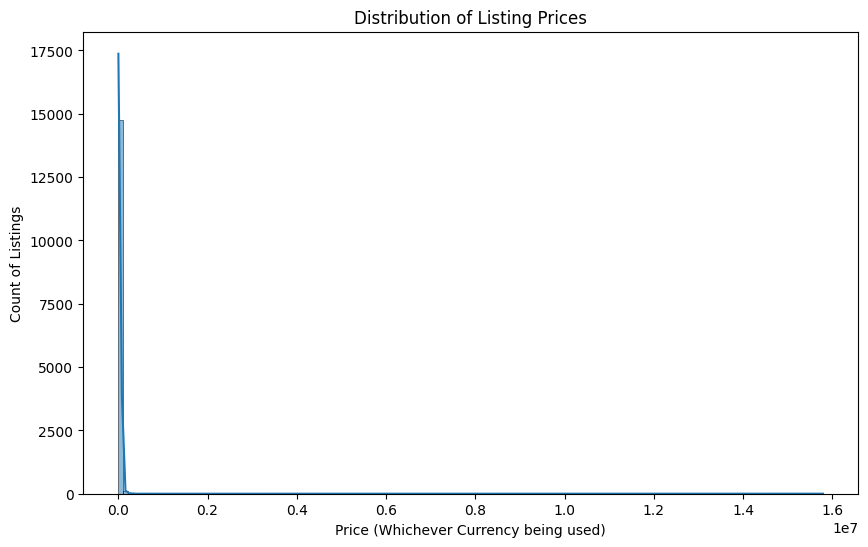

In [ ]:
# plot the price range in histogram for seeing price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['price'], bins=140, kde=True)
plt.xlabel("Price (Whichever Currency being used)")
plt.ylabel("Count of Listings")
plt.title("Distribution of Listing Prices")
plt.show()

Due to massive outliers in the price, its hard to see the actual distribution in price, we have to use other methods to see the proper distribution.

It might be good practice to remove the high percentile listings as their values might be skewing the data heavily.

In [ ]:
# Removing high percentile outliers
# Define a reasonable threshold (e.g., 99th percentile)
price_threshold = np.percentile(df_cleaned["price"], 95)

# Filter data
# Comment/Uncomment out the df_filtered line if you want to separate 2 datasets
# 1 with all the listings, 1 with the top 0.5 percentile listings based onn price removed.
# df_filtered = df_cleaned[df_cleaned["price"] <= price_threshold] # Comment/Uncomment accordingly
df_cleaned = df_cleaned[df_cleaned["price"] <= price_threshold]
print(df_cleaned.shape[0])
# print(df_filtered.shape[0]) # Comment/Uncomment accordingly

14132


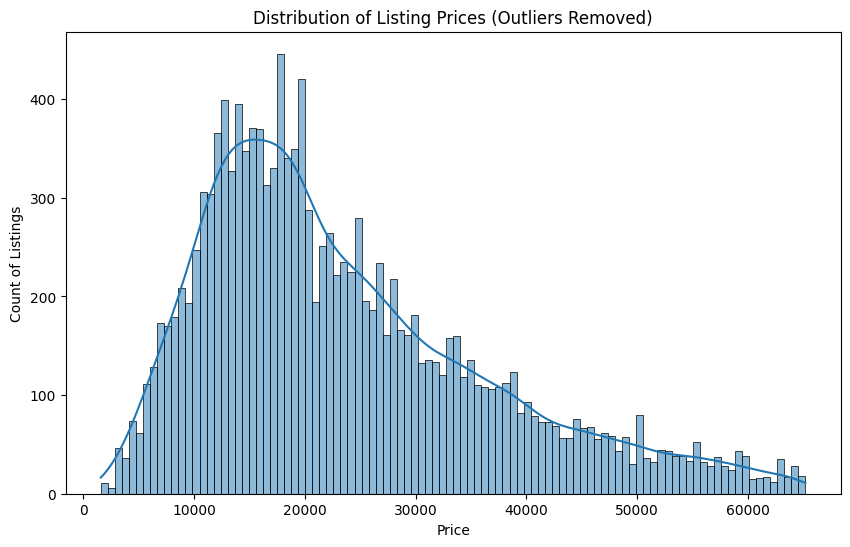

In [ ]:
# Replot
plt.figure(figsize=(10, 6))
# sns.histplot(df_filtered["price"], bins=100, kde=True) # Comment/Uncomment accordingy
sns.histplot(df_cleaned["price"], bins=100, kde=True) # Uncomment this to run the filtered base dataset, if the the outlier was removed
plt.xlabel("Price")
plt.ylabel("Count of Listings")
plt.title("Distribution of Listing Prices (Outliers Removed)")
plt.show()

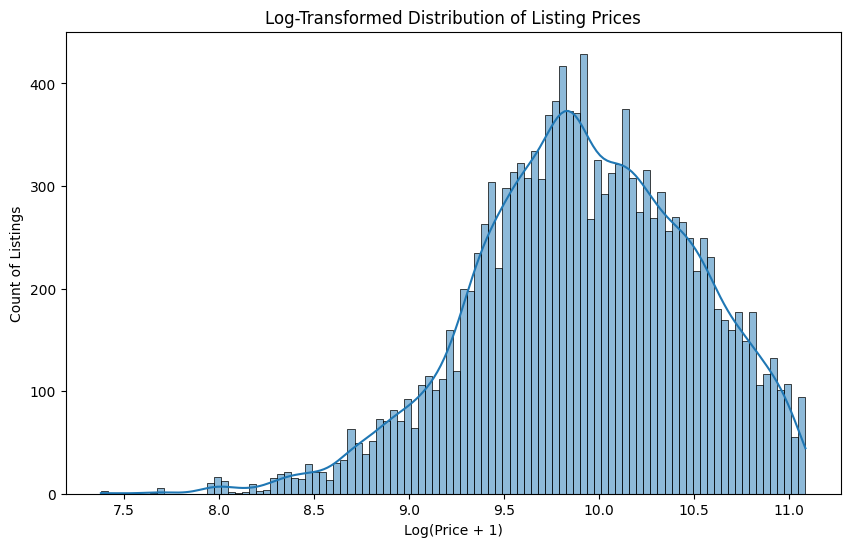

In [ ]:
# Log transformation post filtered
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_cleaned["price"]), bins=100, kde=True)  # log1p avoids log(0)
plt.xlabel("Log(Price + 1)")
plt.ylabel("Count of Listings")
plt.title("Log-Transformed Distribution of Listing Prices")
plt.show()

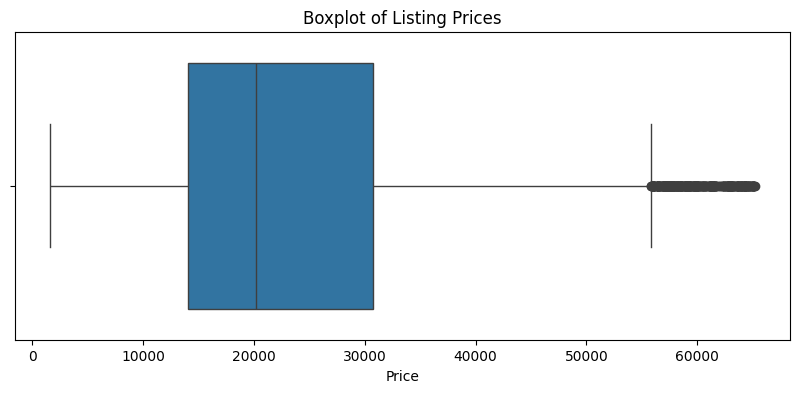

In [ ]:
# Boxplot to see outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_cleaned["price"])
plt.xlabel("Price")
plt.title("Boxplot of Listing Prices")
plt.show()

As we can the majority of the distribution lies in the area between 0.0 ~ 0.2 (1000 ~ 30000). Keep in mind the price follows the le7 nototation in the boxplot if the outlier was not removed.

If the outlier was not removed, then the outlier at the far right should be the listing with the $15789885.0 price. There are also 2 other outilers from 0.4 ~ 0.8 (60000~ onwards), so this should be accounted for as well.

For fair analysis, it might be good to remove the outliers, as it may skew the numbers greatly.

**Outliers**

We are going to separate more outliers from the curve and perform analysis to see if the data is actually accurate.

In [ ]:
# check here WIP
# Compute KDE (smoothed curve from histogram)
kde = sns.kdeplot(df_cleaned["price"], bw_adjust=0.5)

# Separate out data with fewer extreme outliers (for further analysis if needed)
peak_price = df_cleaned["price"].mode()[0]
threshold = 3 * peak_price
df_cleaned_no_outliers = df_cleaned[df_cleaned["price"] <= threshold]
df_cleaned_outliers = df_cleaned[df_cleaned["price"] > threshold]
print("Shape of cleaned data:", df_cleaned.shape[0])

IndentationError: unexpected indent (<ipython-input-1110-aea4da30bcb8>, line 6)

In [ ]:
df_cleaned.shape[0]

14132

### 1.1.3 Analysis of Physical Attributes

This section we will be delving deeper into analysing each feature and its relationship to a listing's price.

First, we can get a heatmap to see just how much of these features correlate to the price of each listing.

**Amenities analysis**

Keep in mind that correlation heatmaps are not entirely accurate to show the true relationship of feature to a listing's price. Amenities for example only have true/false values and not much variance; other forms of analysis may be better suited to understand which feature may have stronger weightage on price.

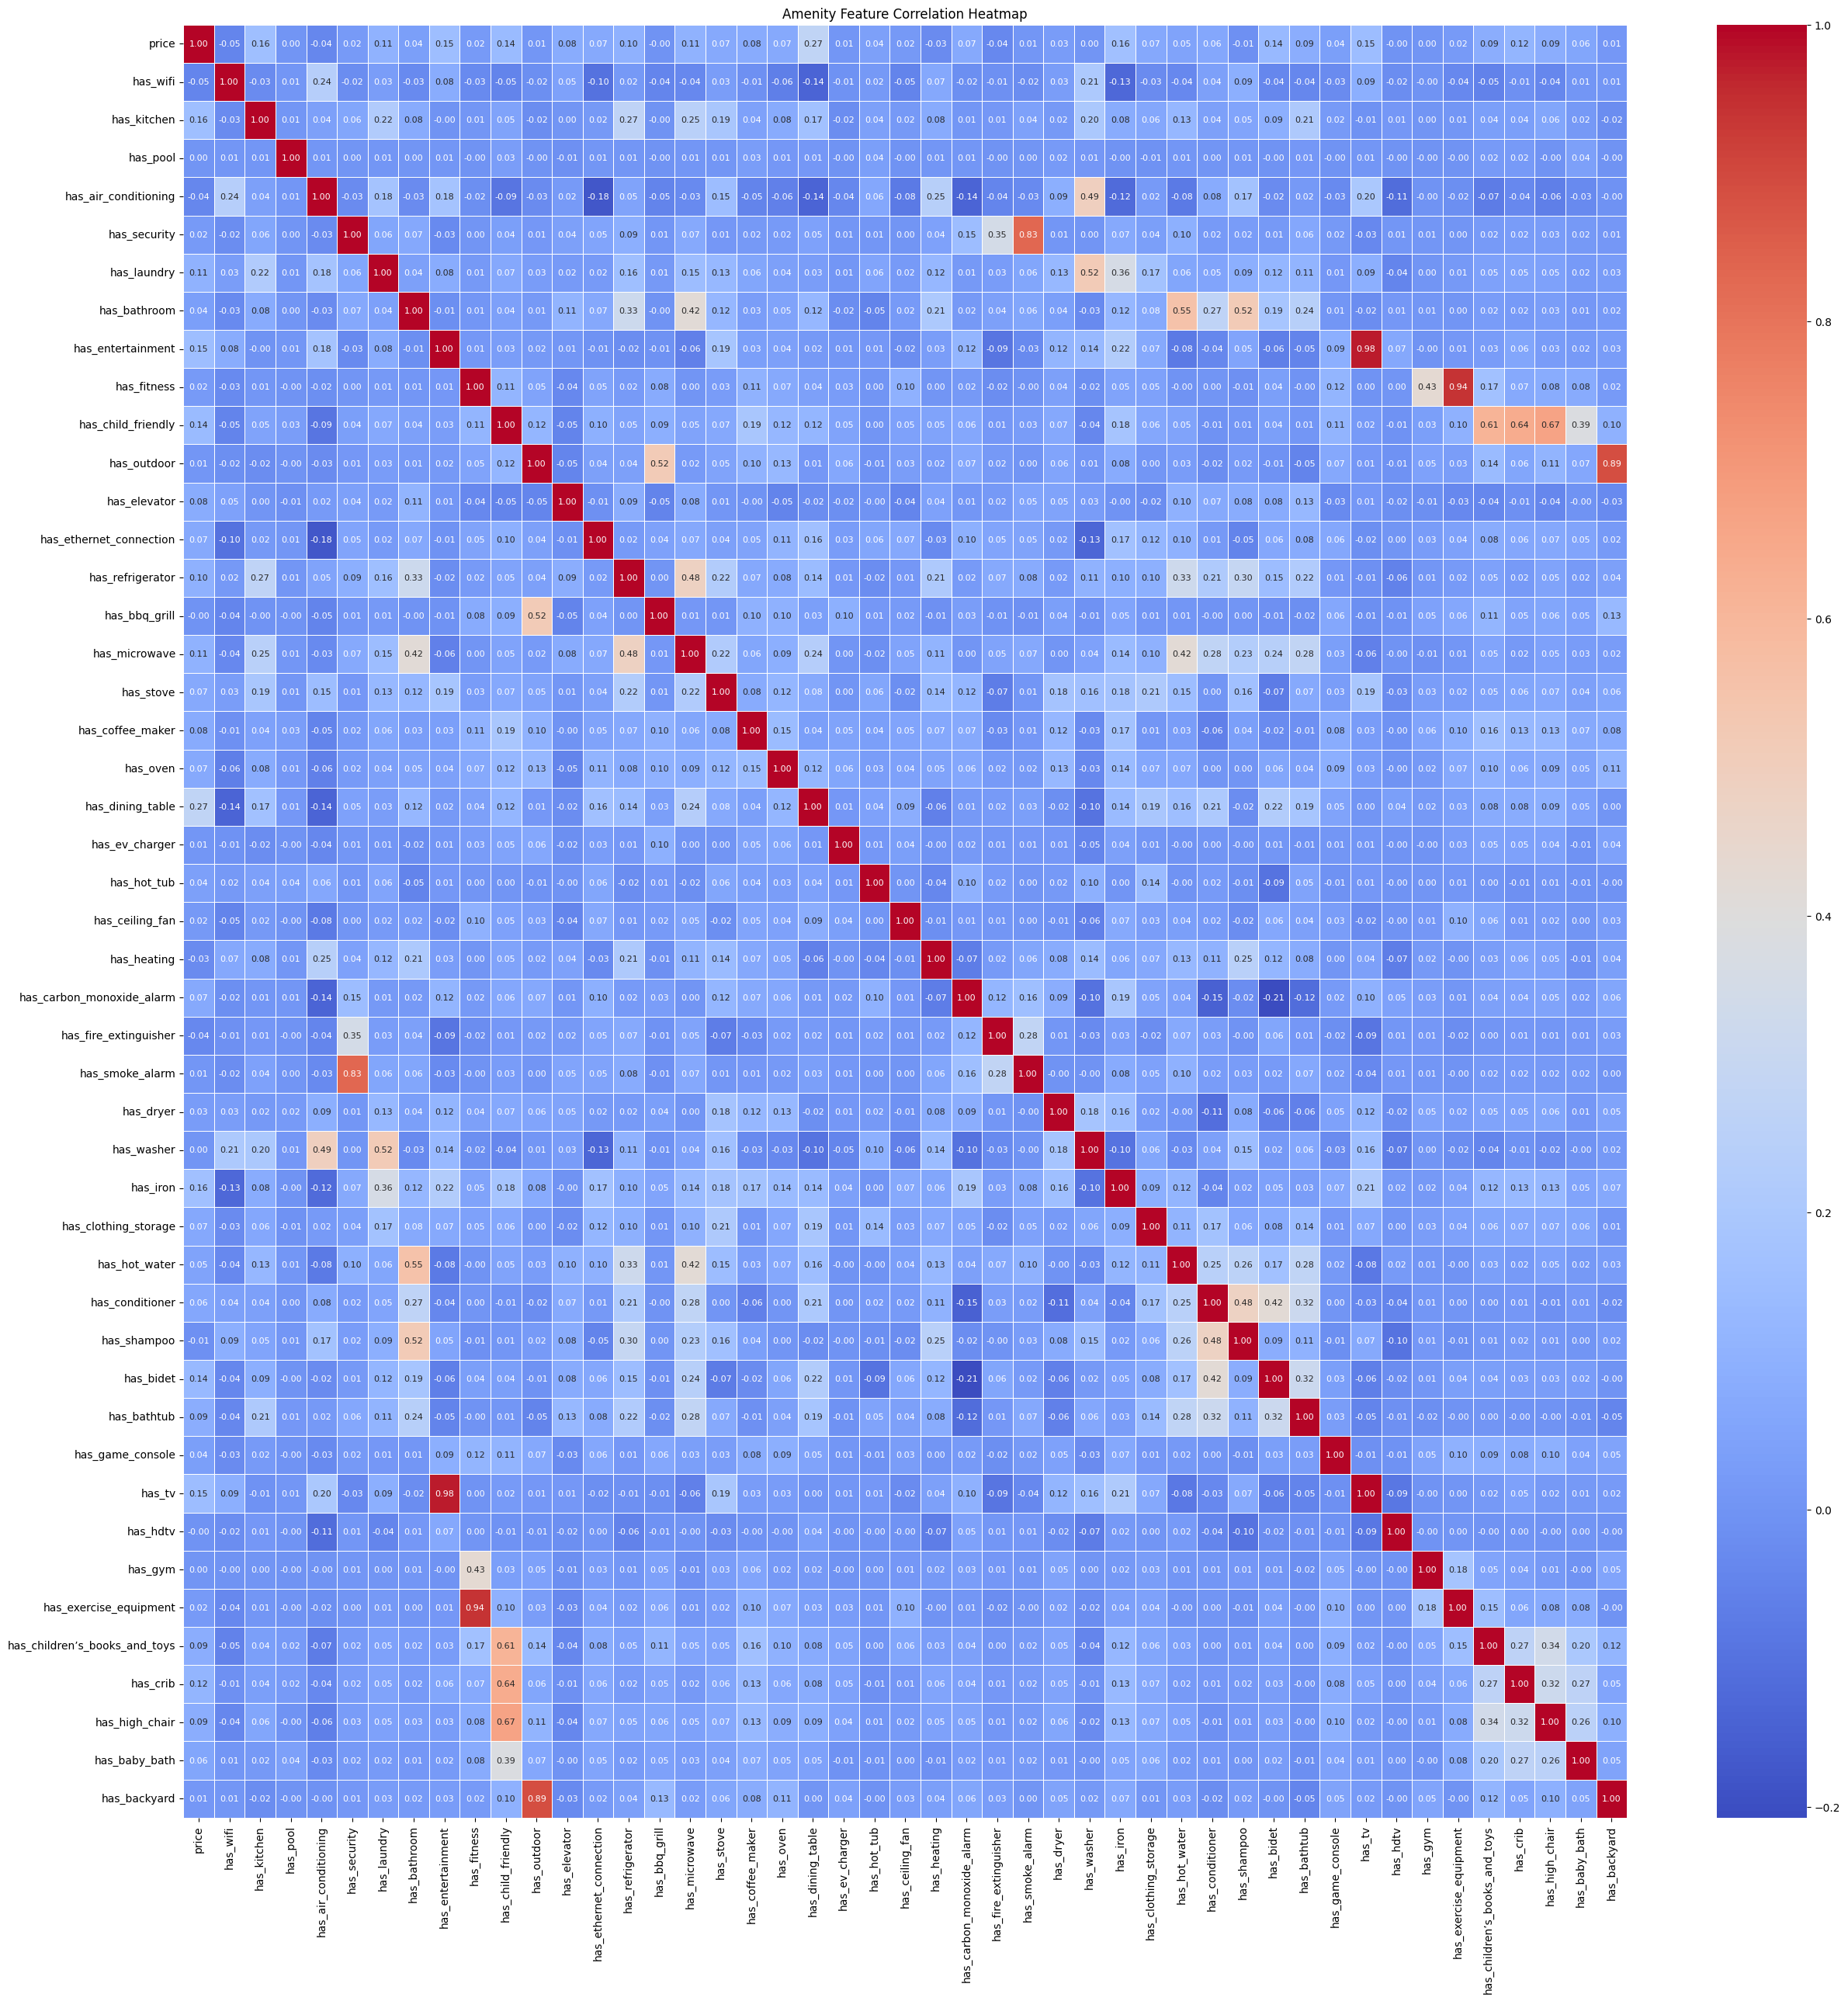

In [ ]:
# amenities only heatmap
amenities_attribute_corr_columns = ['price']
amenities_attribute_corr_columns.extend([col for col in df_cleaned.columns if col.startswith('has_')])
corr_matrix = df_cleaned[amenities_attribute_corr_columns]
# get rid of any columns that have constant values, offers nothing to correlate
corr_matrix = corr_matrix.loc[:, corr_matrix.nunique() > 1]
corr_matrix = corr_matrix.corr()

plt.figure(figsize=(30,30))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

plt.title("Amenity Feature Correlation Heatmap")
plt.xticks(rotation=90)
plt.show()

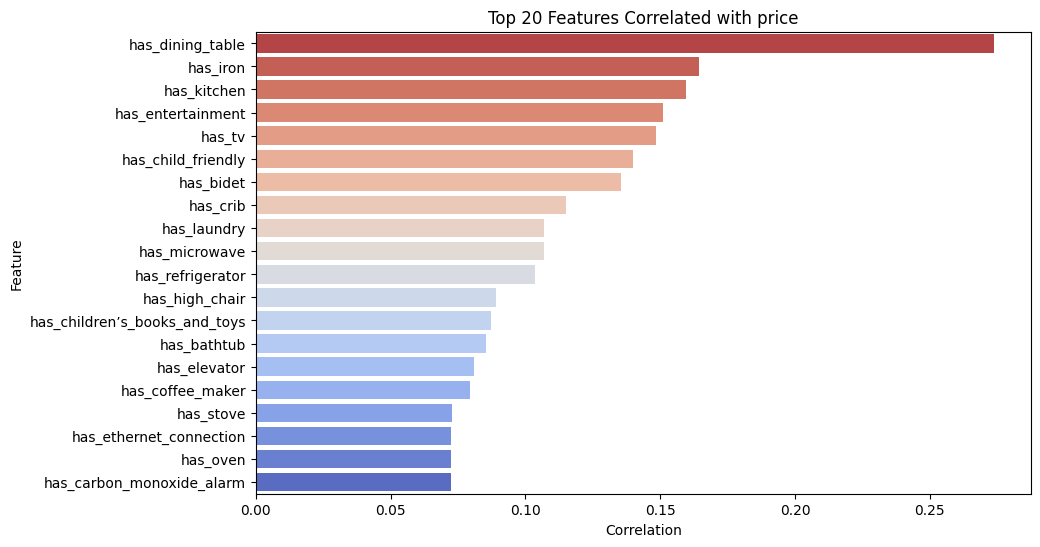

In [ ]:
# Top 20 Most Correlated Features to 'Price'
target_feature = 'price'
top_10_corr = corr_matrix[target_feature].abs().sort_values(ascending=False)[1:21]  # Exclude self-correlation

# Plot Top 20 Correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette="coolwarm_r", hue=top_10_corr.index, legend="auto")  # "_r" reverses colors
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title(f"Top 20 Features Correlated with {target_feature}")
plt.show()

In [ ]:
# Compare mean price for listings with and without each amenity
check_mean = df_cleaned[amenities_attribute_corr_columns]
results = []
for amenity in amenities_attribute_corr_columns[1:]:
    mean_with = check_mean.loc[check_mean[amenity] == 1, "price"].mean()
    mean_without = check_mean.loc[check_mean[amenity] == 0, "price"].mean()
    results.append([amenity, mean_with, mean_without])
df_amenity_means = pd.DataFrame(results, columns=["Amenity", "Mean Price (With)", "Mean Price (Without)"])
df_amenity_means = df_amenity_means.dropna()
df_amenity_means["Price Difference"] = df_amenity_means["Mean Price (With)"] - df_amenity_means["Mean Price (Without)"]
df_amenity_means = df_amenity_means.sort_values("Price Difference", ascending=False)

plt.figure(figsize=(18, 10))
sns.barplot(data=df_amenity_means, x="Price Difference", y="Amenity", palette="coolwarm_r", legend="auto", hue="Amenity")
plt.title("Impact of Amenities on Listing Price")
plt.xlabel("Difference in Mean Price")
plt.ylabel("Amenity")
plt.show()

Apparently having a dinner table in your AirBnB might have the greatest positive impact on your price listing.

We can do other forms of analysis with amenities.

In [ ]:
# Current mean of all listings without any changes
print("Current price mean:")
print(df_cleaned.price.mean())

Current price mean:
23650.539343334276


We can check the mean price of all listings with any one amenitiy, and check against the mean price of all listings.

By doing so, we can see if there are any sizable increase in mean price listings based if a listing has a particular amenity.

In [ ]:
amenities_attribute_corr_columns = ['price']
amenities_attribute_corr_columns.extend([col for col in df_cleaned.columns if col.startswith('has_')])
check_mean = df_cleaned[amenities_attribute_corr_columns]

# Create a results list
results = []

# Iterate through each amenity column (excluding 'price')
for amenity in amenities_attribute_corr_columns[1:]:
    mean_with = check_mean.loc[check_mean[amenity] == 1, "price"].mean()
    mean_without = check_mean.loc[check_mean[amenity] == 0, "price"].mean()

    # Append to results
    results.append([amenity, mean_with, mean_without])

# Convert to DataFrame
df_amenity_means = pd.DataFrame(results, columns=["Amenity", "Mean Price (With)", "Mean Price (Without)"])

# Display the DataFrame
df_amenity_means

Amenity  Mean Price (With)  Mean Price (Without)
0                        has_wifi       23469.311765          25582.437294
1                     has_kitchen       24507.721514          18615.844844
2                        has_pool       25921.750000          23649.896305
3            has_air_conditioning       23445.084053          24832.987572
4                    has_security       23697.591868          21712.677612
5                     has_laundry       24132.202504          19624.345695
6                    has_bathroom       23736.092501          20884.589623
7               has_entertainment       25385.580523          21420.573739
8                     has_fitness       26821.448598          23626.347736
9              has_child_friendly       30428.338591          23161.525833
10                    has_outdoor       24430.036066          23633.344977
11                   has_elevator       25144.801489          22905.943066
12        has_ethernet_connection       25965.826933          23267.744619
13               has_refrigerator       24258.327626          20668.998746
14                  has_bbq_grill       23159.951807          23653.437682
15                  has_microwave       24183.455785          20013.369878
16                      has_stove       24964.833748          22969.388053
17               has_coffee_maker       27823.676005          23393.147322
18                       has_oven       27010.282376          23387.246242
19               has_dining_table       28354.553377          20951.755345
20                 has_ev_charger       25631.292683          23644.776027
21                    has_hot_tub       26050.831230          23537.797822
22                has_ceiling_fan       25611.904545          23619.522930
23                    has_heating       23463.997320          24260.195409
24      has_carbon_monoxide_alarm       24644.144719          22761.131286
25          has_fire_extinguisher       23446.144766          24698.748482
26                has_smoke_alarm       23673.409770          22997.248954
27                      has_dryer       24542.384484          23524.244446
28                     has_washer       23683.747360          23576.577757
29                       has_iron       25700.021704          21415.512130
30           has_clothing_storage       25437.505230          23195.548384
31                  has_hot_water       23862.710323          21550.913647
32                has_conditioner       24188.431974          22388.834754
33                    has_shampoo       23592.554231          24152.284836
34                      has_bidet       25311.359344          21773.950414
35                    has_bathtub       24449.935335          22099.807572
36               has_game_console       28186.730263          23601.218813
37                         has_tv       25397.005141          21511.448678
38                       has_hdtv       23050.333333          23654.386270
39                        has_gym       24441.900000          23649.417800
40         has_exercise_equipment       26697.273684          23629.919570
41  has_children’s_books_and_toys       30560.187668          23463.222036
42                       has_crib       32349.299754          23392.587031
43                 has_high_chair       30104.494331          23442.651377
44                  has_baby_bath       31061.773333          23571.031040
45                   has_backyard       24729.152893          23631.747084

We can list out the prices and compare them to see if they are above the mean or below it.

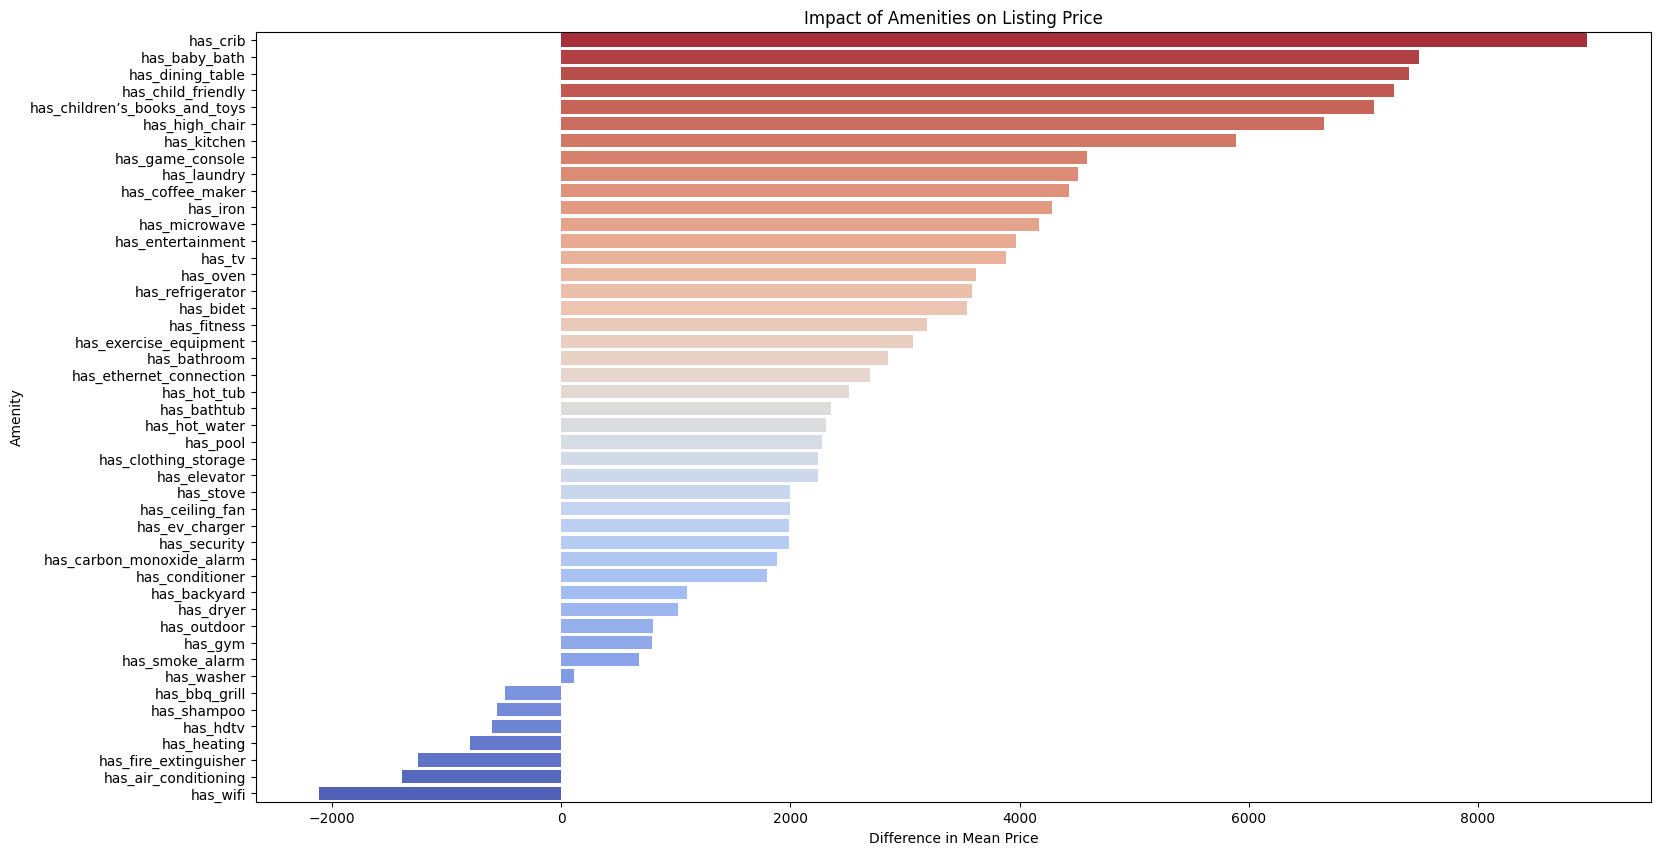

In [ ]:
# get rid of the columns with empty values
df_amenity_means = df_amenity_means.dropna()

# Sort by price difference
df_amenity_means["Price Difference"] = df_amenity_means["Mean Price (With)"] - df_amenity_means["Mean Price (Without)"]
df_amenity_means = df_amenity_means.sort_values("Price Difference", ascending=False)

# Plot
plt.figure(figsize=(18, 10))
sns.barplot(data=df_amenity_means, x="Price Difference", y="Amenity", palette="coolwarm_r", legend="auto", hue="Amenity")
plt.title("Impact of Amenities on Listing Price")
plt.xlabel("Difference in Mean Price")
plt.ylabel("Amenity")
plt.show()

Below is a chi-squared analysis of amenity and prices

In [ ]:
# Chi Squared Analysis
import scipy.stats as stats
# amenities_attribute_corr_columns = ['price']
# amenities_attribute_corr_columns.extend([col for col in df_cleaned.columns if col.startswith('has_')])
# chi_sq = df_cleaned[amenities_attribute_corr_columns].copy()

# # chi_sq['price_category'] = pd.qcut(chi_sq['price'], q=3, labels=["Low", "Medium", "High"])
# chi_sq['price_category'] = pd.qcut(chi_sq['price'], q=3, labels=["Low", "Medium", "High"])
# contigency_table = pd.crosstab(chi_sq['price_category'], chi_sq['has_wifi'])
# print(contigency_table)

# chi2, p, dof, expected = stats.chi2_contingency(contigency_table)
# print("Chi-Squared Value:", chi2)
# print("P-Value:", p)

# # Interpretation
# if p < 0.05:
#     print("Significant relationship between has_pool and price category!")
# else:
#     print("No significant relationship found.")
# Select relevant columns
amenities_attribute_corr_columns = ['price']
amenities_attribute_corr_columns.extend([col for col in df_cleaned.columns if col.startswith('has_')])
chi_sq = df_cleaned[amenities_attribute_corr_columns].copy()

# Create price categories
chi_sq['price_category'] = pd.qcut(chi_sq['price'], q=3, labels=["Low", "Medium", "High"])
print(chi_sq['price_category'].value_counts())

# Store results
significant_amenities = []

# Iterate over all amenities
for amenity in [col for col in chi_sq.columns if col.startswith('has_')]:
    contigency_table = pd.crosstab(chi_sq['price_category'], chi_sq[amenity])

    # Perform Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contigency_table)

    # Check significance (p < 0.05 means significant relationship)
    if p < 0.05:
        significant_amenities.append((amenity, p))

# Sort by p-value (ascending)
significant_amenities.sort(key=lambda x: x[1])

print(f"{len(significant_amenities)} amenities have postive impact on price.\n")

# Print results
print("Amenities with a significant relationship to price category:")
for amenity, p_value in significant_amenities:
    print(f"{amenity}: p-value = {p_value:.5f}")


price_category
Medium    4732
Low       4723
High      4677
Name: count, dtype: int64
36 amenities have postive impact on price.

Amenities with a significant relationship to price category:
has_dining_table: p-value = 0.00000
has_iron: p-value = 0.00000
has_kitchen: p-value = 0.00000
has_entertainment: p-value = 0.00000
has_tv: p-value = 0.00000
has_elevator: p-value = 0.00000
has_child_friendly: p-value = 0.00000
has_bidet: p-value = 0.00000
has_laundry: p-value = 0.00000
has_bathtub: p-value = 0.00000
has_refrigerator: p-value = 0.00000
has_crib: p-value = 0.00000
has_microwave: p-value = 0.00000
has_high_chair: p-value = 0.00000
has_children’s_books_and_toys: p-value = 0.00000
has_oven: p-value = 0.00000
has_coffee_maker: p-value = 0.00000
has_stove: p-value = 0.00000
has_carbon_monoxide_alarm: p-value = 0.00000
has_ethernet_connection: p-value = 0.00000
has_conditioner: p-value = 0.00000
has_baby_bath: p-value = 0.00000
has_clothing_storage: p-value = 0.00000
has_hot_water: p-valu

**Room types**

Analysing what kind of effect the room type has on price.

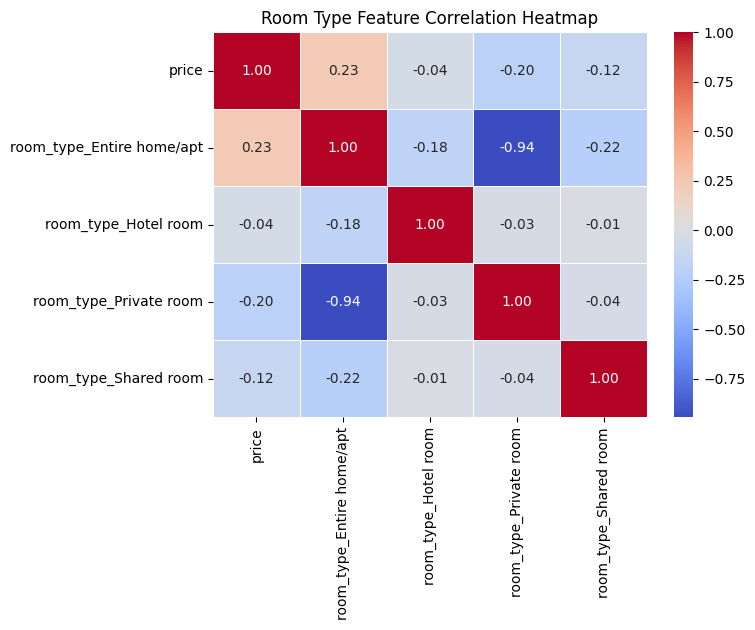

In [ ]:
# room_types only heatmap
room_types_attribute_corr_columns = ['price', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
corr_matrix = df_cleaned[room_types_attribute_corr_columns].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Room Type Feature Correlation Heatmap")
plt.show()

**Other physical attributes**

Here we can see the heatmap and other visual representation for each feature.

The graphs itself is pretty self-explanatory and simply shows the relationship between the features and price.

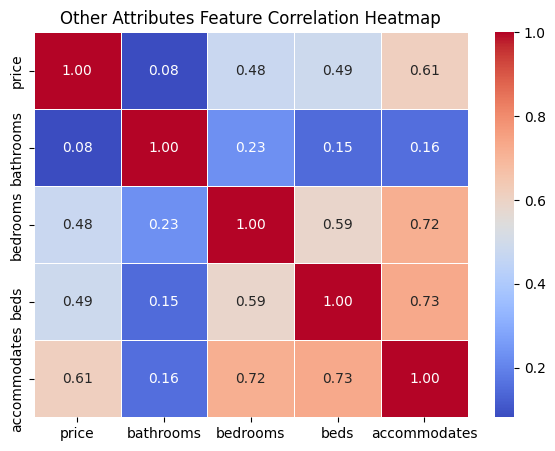

In [ ]:
# the rest of the physical attribute features
other_atritbutes_corr_columns = ['price', 'bathrooms', 'bedrooms', 'beds', 'accommodates']
corr_matrix = df_cleaned[other_atritbutes_corr_columns].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show plot
plt.title("Other Attributes Feature Correlation Heatmap")
plt.show()

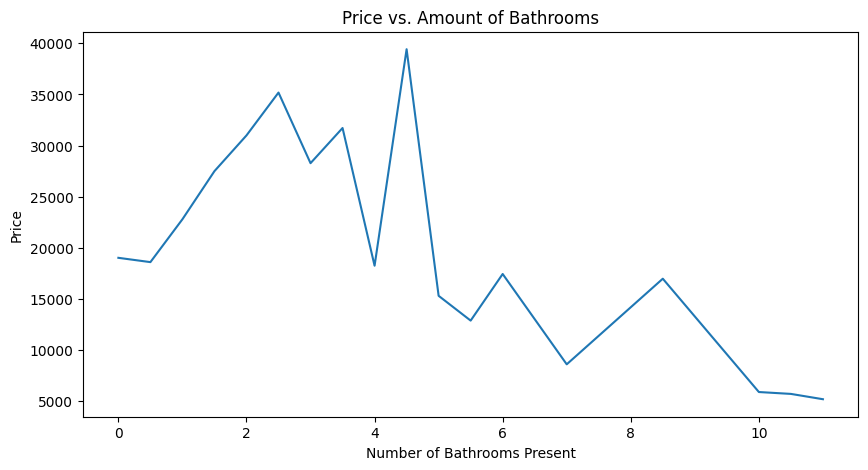

In [ ]:
# Price against bathrooms graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x="bathrooms", y="price", errorbar=None)
plt.xlabel("Number of Bathrooms Present")
plt.ylabel("Price")
plt.title("Price vs. Amount of Bathrooms")
plt.show()

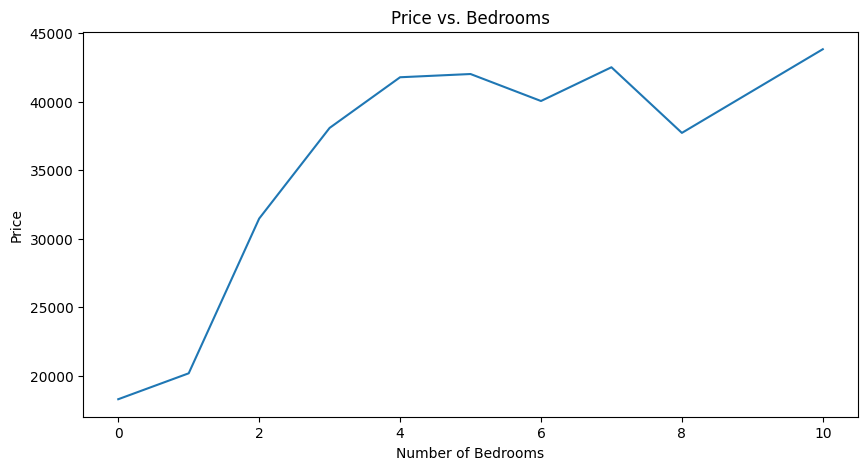

In [ ]:
# Price against bedrooms graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x="bedrooms", y="price", errorbar=None)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")
plt.title("Price vs. Bedrooms")
plt.show()

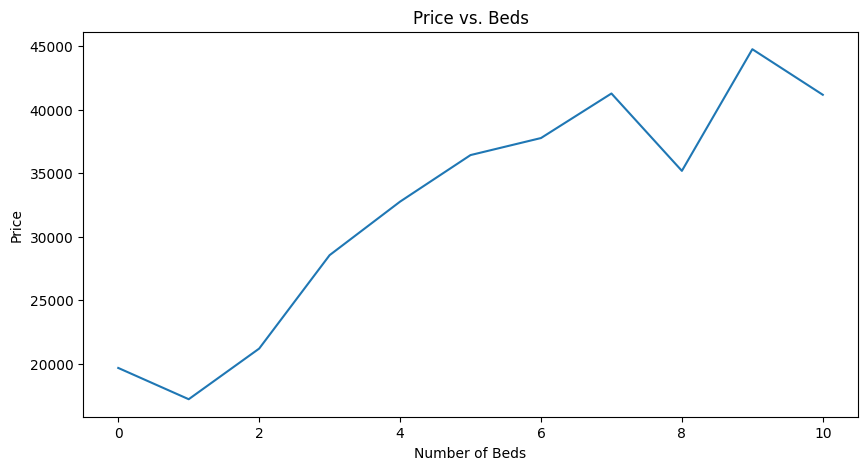

In [ ]:
# Price against beds graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x="beds", y="price", errorbar=None)
plt.xlabel("Number of Beds")
plt.ylabel("Price")
plt.title("Price vs. Beds")
plt.show()

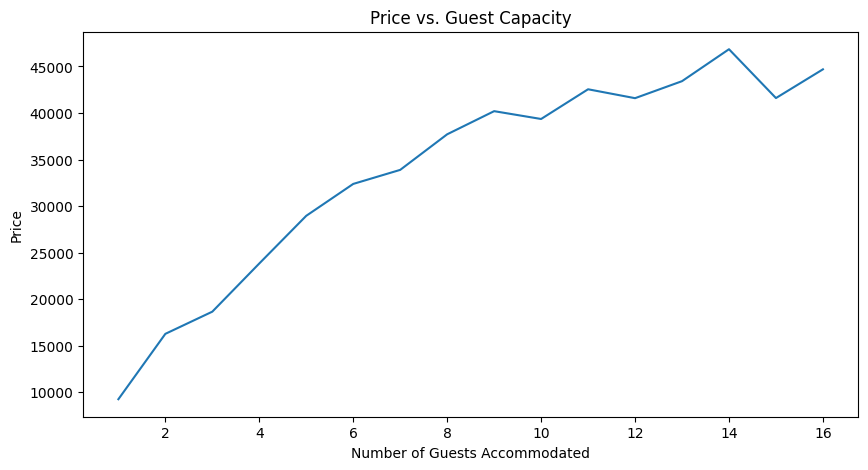

In [ ]:
# Price against accomodation graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x="accommodates", y="price", errorbar=None)
plt.xlabel("Number of Guests Accommodated")
plt.ylabel("Price")
plt.title("Price vs. Guest Capacity")
plt.show()

Currently due to outliers in the dataset, some of the graphs look pretty inaccurate.

Will have to discuss if want to remove them in the future.

## 1.2 Location Attributes

Unknown if want to proceed with this.

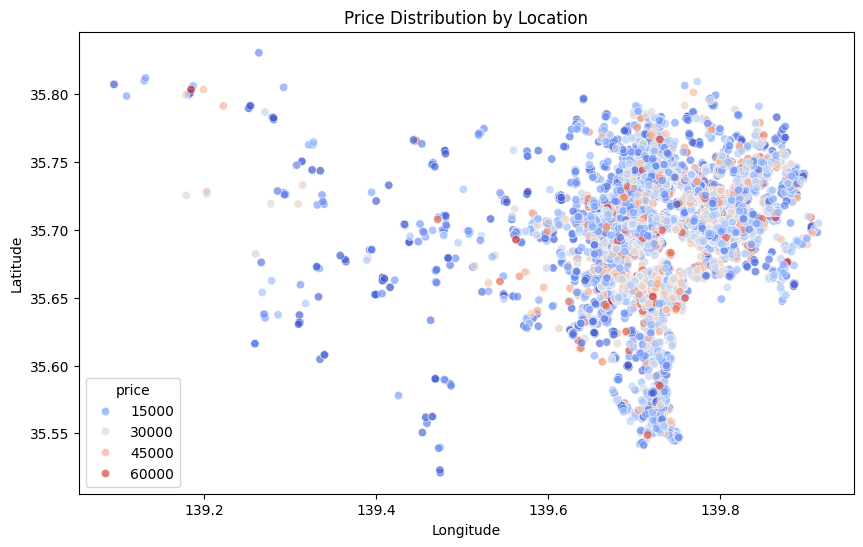

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x="longitude", y="latitude", hue="price", palette="coolwarm", alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Price Distribution by Location")
plt.show()

## 1.3 Host Atttributes

Feature Engineering with features corresponding to host information

The list of Host attribute features consists of:

 * 'host_response_time'
 * 'host_response_rate'
 * 'host_acceptance_rate'
 * 'host_is_superhost'
 * 'host_identity_verified'

In [ ]:
host_attributes = ['price','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_identity_verified']
df_cleaned[host_attributes].head()

price  host_response_time host_response_rate host_acceptance_rate  \
0  13000.0        within a day               100%                  93%   
1   9474.0      within an hour               100%                 100%   
2  39363.0      within an hour               100%                 100%   
3  26571.0  within a few hours               100%                 100%   
4  10571.0      within an hour               100%                  92%   

  host_is_superhost host_identity_verified  
0                 t                      t  
1                 t                      t  
2                 t                      f  
3                 t                      t  
4                 t                      t

**Cleaning Features**

We have to clean the data once again and see the relationship between these features and price.

**Response Time and Rate, Acceptance Rate**

These features are unique and have to be normalised/tagged before they are able to be used for the model.

In [ ]:
# pull the values and see unique counts, whats available
# start with response time and rate, with acceptance rate
print("Response time data:\n")
print(df_cleaned.host_response_time.unique())
print(df_cleaned.host_response_time.value_counts())
print("\nResponse rate data:\n")
print(df_cleaned.host_response_rate.unique())
print(df_cleaned.host_response_rate.value_counts())
print("\nAcceptance rate data:\n")
print(df_cleaned.host_acceptance_rate.unique())
print(df_cleaned.host_acceptance_rate.value_counts())

Response time data:

['within a day' 'within an hour' 'within a few hours' 'a few days or more']
host_response_time
within an hour        13455
within a few hours      559
within a day            108
a few days or more       10
Name: count, dtype: int64

Response rate data:

['100%' '98%' '92%' '89%' '0%' '40%' '90%' '95%' '99%' '96%' '82%' '80%'
 '97%' '60%' '83%' '93%' '70%' '84%' '94%' '50%' '78%' '67%' '91%' '86%'
 '88%' '87%' '63%' '85%' '56%' '69%' '75%' '71%' '10%' '33%']
host_response_rate
100%    12853
99%       423
90%       152
98%       149
95%        89
97%        86
80%        63
96%        62
93%        47
92%        42
94%        21
50%        16
86%        14
85%        13
89%        13
83%        13
91%        13
88%        12
60%         9
84%         6
67%         5
63%         5
0%          5
78%         4
70%         3
40%         3
82%         2
87%         2
69%         2
56%         1
75%         1
71%         1
10%         1
33%         1
Name: count, dtype: i

We can encode the values for the response time, and convert the percentages into numerical values and normalise them.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
unique_response_time = df_cleaned.host_response_time.unique()
mapped = le.fit_transform(unique_response_time)

mapping = dict(zip(mapped, unique_response_time))
sorted_dict = dict(sorted(mapping.items()))
print(sorted_dict)

df_cleaned['host_response_time'] = le.fit_transform(df_cleaned['host_response_time'])
df_cleaned_no_outliers['host_response_time'] = le.fit_transform(df_cleaned_no_outliers['host_response_time'])
df_cleaned['host_response_time'].head()

{0: 'a few days or more', 1: 'within a day', 2: 'within a few hours', 3: 'within an hour'}


<ipython-input-1064-57494282c519>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers['host_response_time'] = le.fit_transform(df_cleaned_no_outliers['host_response_time'])


0    1
1    3
2    3
3    2
4    3
Name: host_response_time, dtype: int64

In [ ]:
# Convert percentage strings to float and normalize
df_cleaned["host_response_rate"] = df_cleaned["host_response_rate"].str.rstrip("%").astype(float) / 100
df_cleaned["host_acceptance_rate"] = df_cleaned["host_acceptance_rate"].str.rstrip("%").astype(float) / 100

# Convert percentage strings to float and normalize
df_cleaned_no_outliers["host_response_rate"] = df_cleaned_no_outliers["host_response_rate"].str.rstrip("%").astype(float) / 100
df_cleaned_no_outliers["host_acceptance_rate"] = df_cleaned_no_outliers["host_acceptance_rate"].str.rstrip("%").astype(float) / 100

<ipython-input-1065-171d2bf06acc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers["host_response_rate"] = df_cleaned_no_outliers["host_response_rate"].str.rstrip("%").astype(float) / 100
<ipython-input-1065-171d2bf06acc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers["host_acceptance_rate"] = df_cleaned_no_outliers["host_acceptance_rate"].str.rstrip("%").astype(float) / 100


In [ ]:
# show the new cleaned values
df_cleaned[["host_response_rate", "host_acceptance_rate"]].head()

host_response_rate  host_acceptance_rate
0                 1.0                  0.93
1                 1.0                  1.00
2                 1.0                  1.00
3                 1.0                  1.00
4                 1.0                  0.92

In [ ]:
# For superhost and verified columns
print(df_cleaned.host_is_superhost.value_counts())
print(f"Percentage of hosts that are superhost: {(df_cleaned.host_is_superhost.value_counts().iloc[0]/df_cleaned.host_is_superhost.value_counts().sum())*100:.2f}")
print(df_cleaned.host_identity_verified.value_counts())
print(f"Percentage of hosts that are verified: {(df_cleaned.host_identity_verified.value_counts().iloc[0]/df_cleaned.host_identity_verified.value_counts().sum())*100:.2f}")

host_is_superhost
f    7908
t    6224
Name: count, dtype: int64
Percentage of hosts that are superhost: 55.96
host_identity_verified
t    13627
f      505
Name: count, dtype: int64
Percentage of hosts that are verified: 96.43


In [ ]:
# one hot encode the superhost and verified columns
df_cleaned["host_is_superhost"] = df_cleaned["host_is_superhost"].map({"t": True, "f": False})
df_cleaned["host_identity_verified"] = df_cleaned["host_identity_verified"].map({"t": True, "f": False})
df_cleaned_no_outliers["host_is_superhost"] = df_cleaned_no_outliers["host_is_superhost"].map({"t": True, "f": False})
df_cleaned_no_outliers["host_identity_verified"] = df_cleaned_no_outliers["host_identity_verified"].map({"t": True, "f": False})

df_cleaned[["host_is_superhost", "host_identity_verified"]].head()

<ipython-input-1068-92d3e065a51e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers["host_is_superhost"] = df_cleaned_no_outliers["host_is_superhost"].map({"t": True, "f": False})
<ipython-input-1068-92d3e065a51e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers["host_identity_verified"] = df_cleaned_no_outliers["host_identity_verified"].map({"t": True, "f": False})


host_is_superhost  host_identity_verified
0               True                    True
1               True                    True
2               True                   False
3               True                    True
4               True                    True

**Analysis**

Now we can further analyse the features and their relationship to price.

As usual we can start with the heatmap.

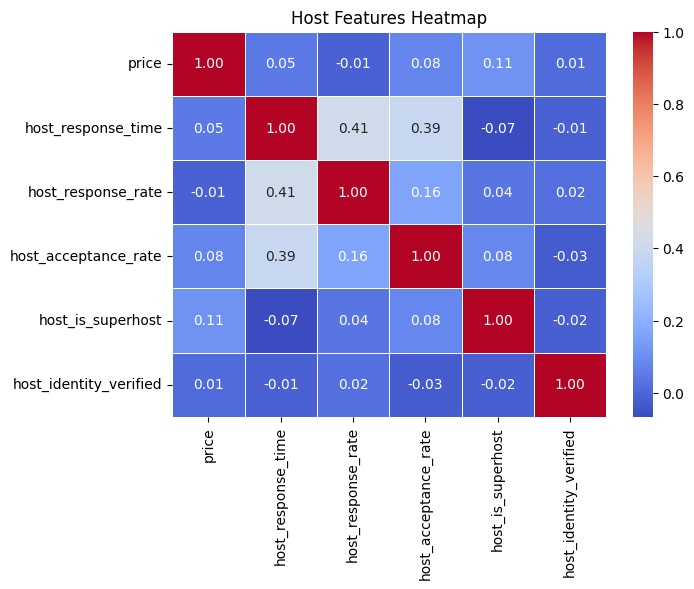

In [ ]:
# generate heatmap
corr_host = df_cleaned[host_attributes].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_host, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show plot
plt.title("Host Features Heatmap")
plt.show()

Lack of variance in data (i.e. actual numerical value) makes it hard to see positive relationships in heatmaps

It would be better to see other forms of analysis.

**Response Time**

Deos response time seem to affect pricing? It seems to be somewhat affected.

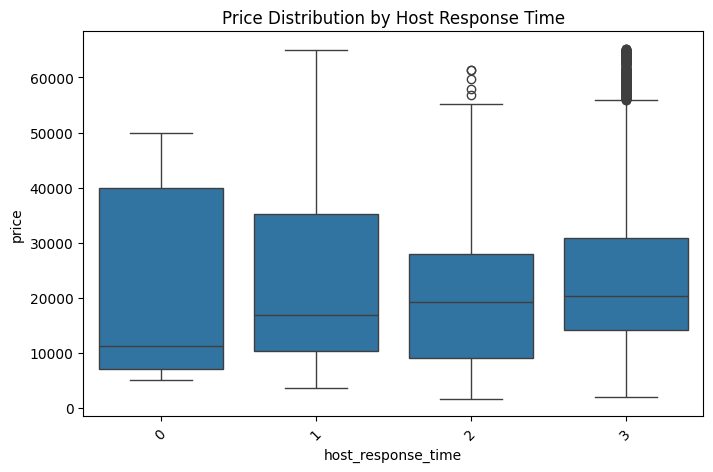

In [ ]:
# Host response time vs. Price
plt.figure(figsize=(8, 5))
sns.boxplot(x="host_response_time", y="price", data=df_cleaned)
plt.xticks(rotation=45)
plt.title("Price Distribution by Host Response Time")
plt.show()

Do higher response/acceptance rates lead to higher/lower prices?
Are there clusters of hosts charging extreme prices with low engagement?

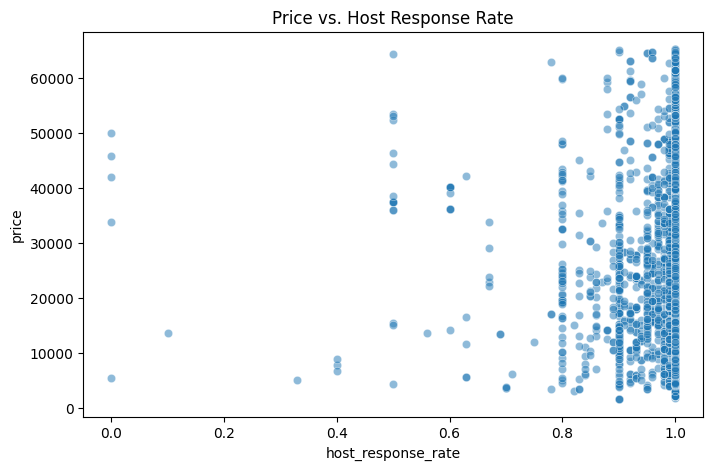

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="host_response_rate", y="price", data=df_cleaned, alpha=0.5)
plt.title("Price vs. Host Response Rate")
plt.show()

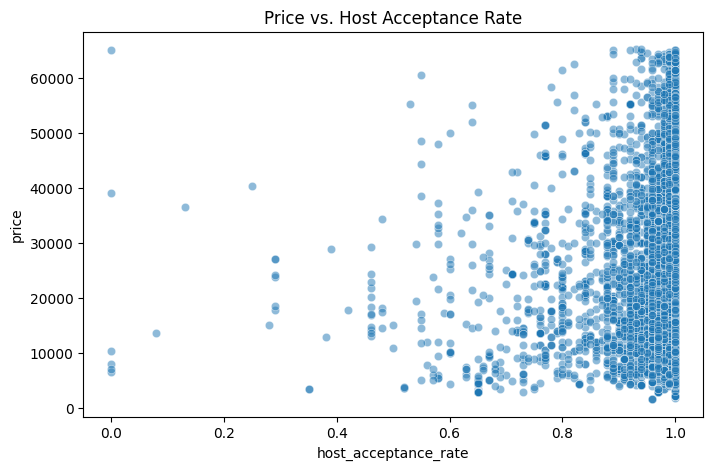

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="host_acceptance_rate", y="price", data=df_cleaned, alpha=0.5)
plt.title("Price vs. Host Acceptance Rate")
plt.show()

23650.539343334276
host_response_time
2    19974.577818
0    21902.300000
1    22346.277778
3    23815.028763
Name: price, dtype: float64
host_is_superhost
False    22347.351796
True     25306.324550
Name: price, dtype: float64


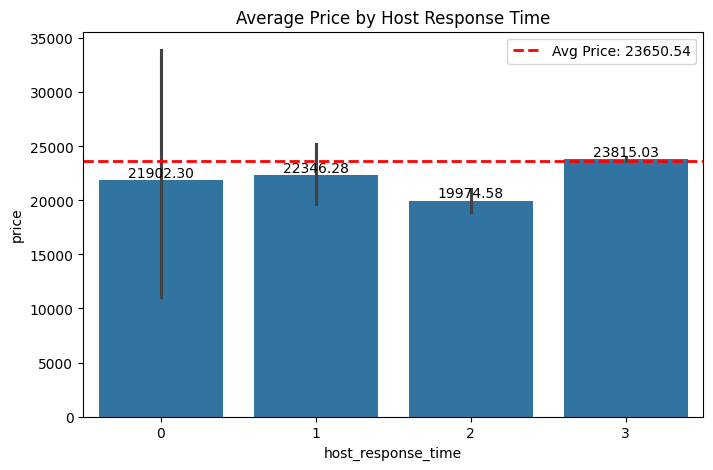

In [ ]:
print(df_cleaned["price"].mean())
print(df_cleaned.groupby("host_response_time")["price"].mean().sort_values())
print(df_cleaned.groupby("host_is_superhost")["price"].mean())

# plot into bar graph
# Calculate overall average price
avg_price = df_cleaned["price"].mean()

# Create bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="host_response_time", y="price", data=df_cleaned, estimator=lambda x: x.mean())

# Add a horizontal line for average price
plt.axhline(avg_price, color='red', linestyle='dashed', linewidth=2, label=f'Avg Price: {avg_price:.2f}')

# Annotate each bar with its mean price
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Add title and legend
plt.title("Average Price by Host Response Time")
plt.legend()
plt.show()


Are Superhosts charging more on average?

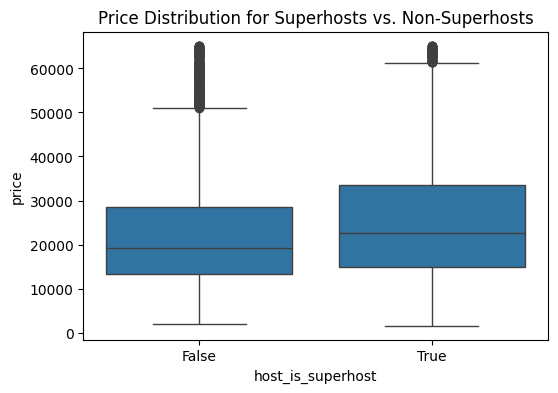

In [ ]:
# Host is superhost vs. Price
plt.figure(figsize=(6, 4))
sns.boxplot(x="host_is_superhost", y="price", data=df_cleaned)
plt.title("Price Distribution for Superhosts vs. Non-Superhosts")
plt.show()

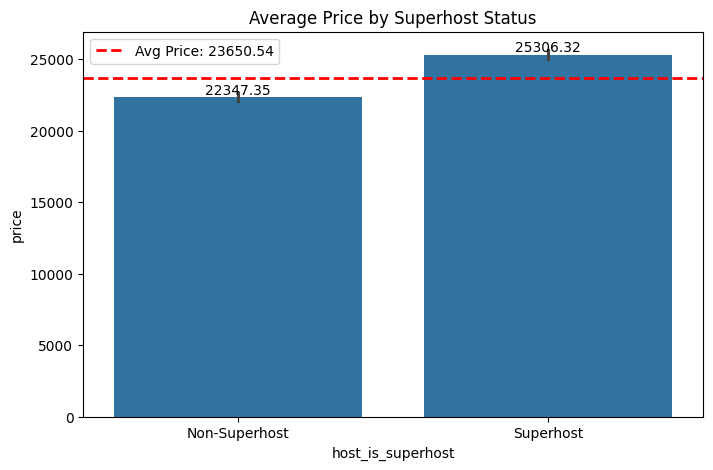

In [ ]:
# Create bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="host_is_superhost", y="price", data=df_cleaned, estimator=lambda x: x.mean())

# Add a horizontal line for average price
plt.axhline(avg_price, color='red', linestyle='dashed', linewidth=2, label=f'Avg Price: {avg_price:.2f}')

# Annotate each bar with its mean price
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Set proper xticks before setting labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Non-Superhost", "Superhost"])

# Add title and legend
plt.title("Average Price by Superhost Status")
plt.legend()
plt.show()


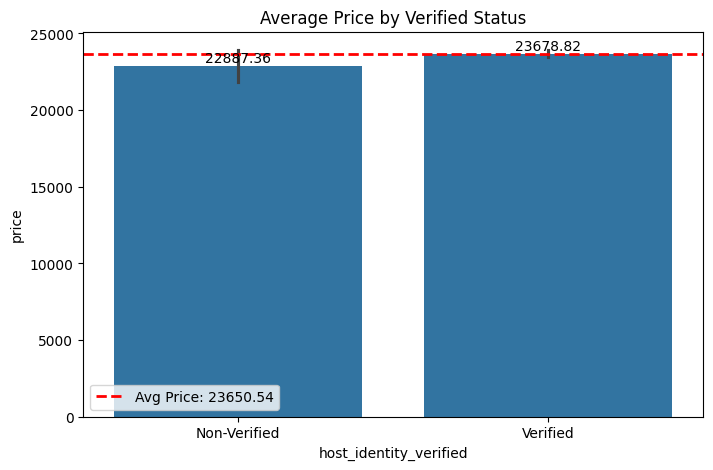

In [ ]:
# Create bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="host_identity_verified", y="price", data=df_cleaned, estimator=lambda x: x.mean())

# Add a horizontal line for average price
plt.axhline(avg_price, color='red', linestyle='dashed', linewidth=2, label=f'Avg Price: {avg_price:.2f}')

# Annotate each bar with its mean price
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Set proper xticks before setting labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Non-Verified", "Verified"])

# Add title and legend
plt.title("Average Price by Verified Status")
plt.legend()
plt.show()

## 1.4 Review Attributes

Feature Engineering with features corresponding to reviews given by users for each listing.

This conists of :

* 'number_of_reviews',
* 'review_scores_rating',
* 'review_scores_accuracy',
* 'review_scores_cleanliness',
* 'review_scores_checkin',
* 'review_scores_communication',
* 'review_scores_location',
* 'review_scores_value',
* 'reviews_per_month',

In [ ]:
review_attributes = ['price',
'number_of_reviews',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value',
'reviews_per_month']
df_cleaned[review_attributes].head()

price  number_of_reviews  review_scores_rating  review_scores_accuracy  \
0  13000.0                183                  4.78                    4.75   
1   9474.0                264                  4.98                    4.97   
2  39363.0                242                  4.80                    4.81   
3  26571.0                271                  4.95                    4.94   
4  10571.0                135                  4.80                    4.89   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.91                   4.85   
1                       4.92                   4.98   
2                       4.79                   4.87   
3                       4.84                   4.94   
4                       4.79                   4.94   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.84                    4.56                 4.80   
1                         4.98                    4.84                 4.92   
2                         4.91                    4.78                 4.78   
3                         4.98                    4.92                 4.90   
4                         4.92                    4.74                 4.82   

   reviews_per_month  
0               1.13  
1               1.79  
2               1.69  
3               1.90  
4               0.97

In [ ]:
# for number of reviews, check the mean and outliers
print(df_cleaned.number_of_reviews.describe())

count    14132.000000
mean        41.858265
std         68.462220
min          1.000000
25%          7.000000
50%         20.000000
75%         50.000000
max       3092.000000
Name: number_of_reviews, dtype: float64


In [ ]:
# normalise the review scores
from sklearn.preprocessing import MinMaxScaler

# Select only the review score columns
review_cols = [
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"
]

# Apply MinMaxScaler (0-5 → 0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_cleaned[review_cols] = scaler.fit_transform(df_cleaned[review_cols])
df_cleaned[review_attributes].head()
df_cleaned_no_outliers[review_cols] = scaler.fit_transform(df_cleaned_no_outliers[review_cols])

<ipython-input-1079-9cc00acb2355>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers[review_cols] = scaler.fit_transform(df_cleaned_no_outliers[review_cols])


In [ ]:
# check the monthly reviews
print(df_cleaned.reviews_per_month.describe())

count    14132.000000
mean         1.816838
std          1.587787
min          0.010000
25%          0.850000
50%          1.490000
75%          2.470000
max         40.090000
Name: reviews_per_month, dtype: float64


<Axes: >

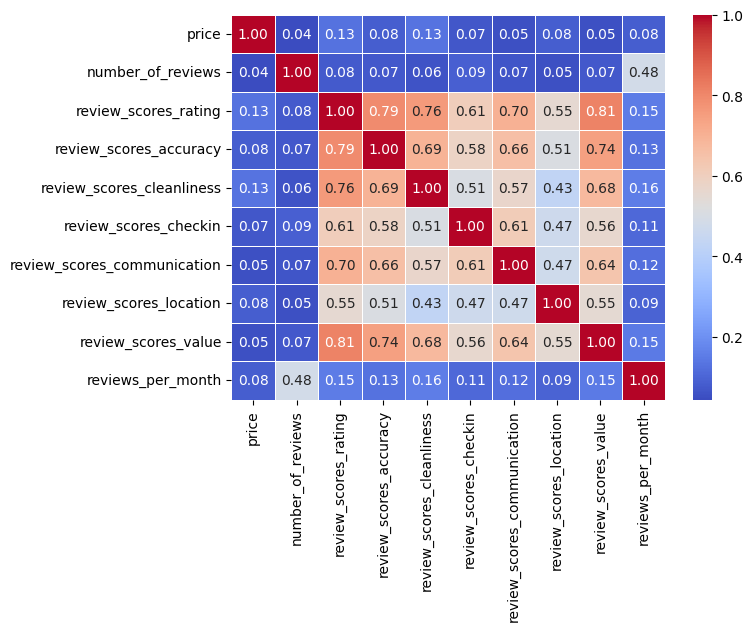

In [ ]:
# heatmap
corr_review = df_cleaned[review_attributes].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_review, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

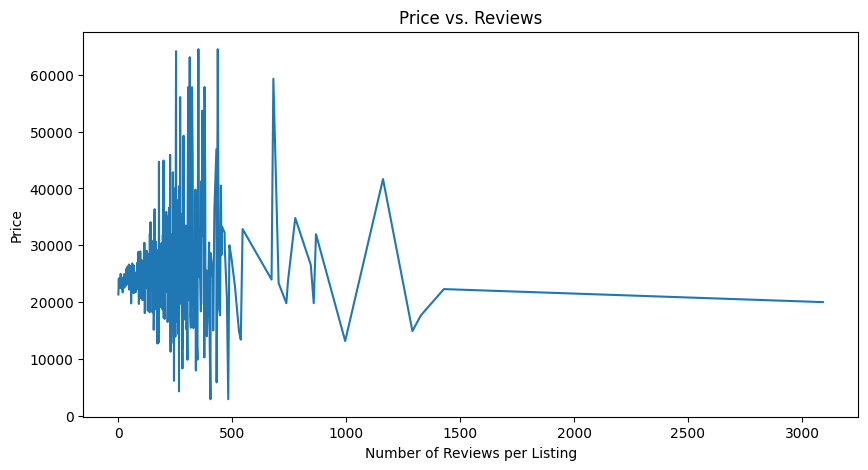

In [ ]:
# prices against number of reviews
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x="number_of_reviews", y="price", errorbar=None)
plt.xlabel("Number of Reviews per Listing")
plt.ylabel("Price")
plt.title("Price vs. Reviews")
plt.show()

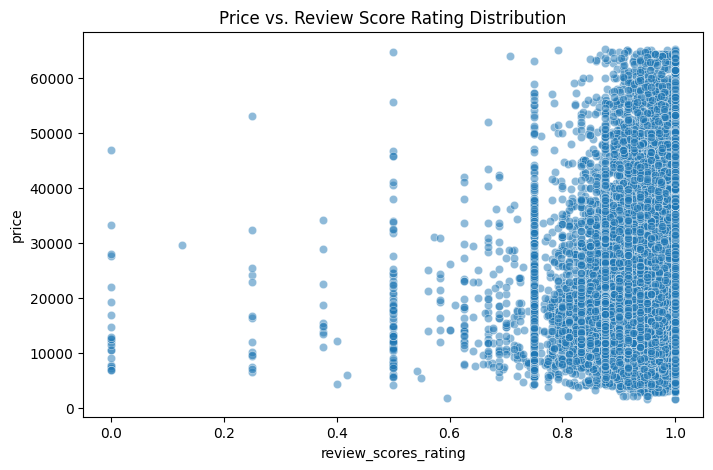

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="review_scores_rating", y="price", data=df_cleaned, alpha=0.5)
plt.title("Price vs. Review Score Rating Distribution")
plt.show()

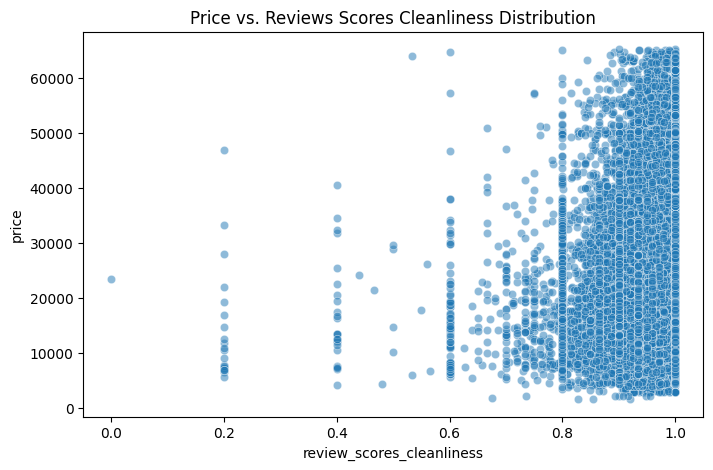

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="review_scores_cleanliness", y="price", data=df_cleaned, alpha=0.5)
plt.title("Price vs. Reviews Scores Cleanliness Distribution")
plt.show()

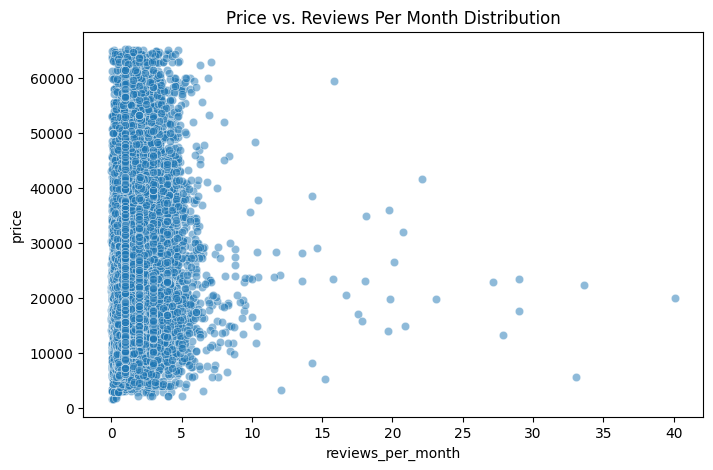

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="reviews_per_month", y="price", data=df_cleaned, alpha=0.5)
plt.title("Price vs. Reviews Per Month Distribution")
plt.show()

There's not much correlation in this dataset to warrent using the reviews statistics as a main feature.

## 1.5 AirBnB Booking Attributes

This is feature engineering on features related to other factors related to the booking process.

This includes:

* 'minimum_nights',
* 'maximum_nights',
* 'minimum_minimum_nights',
* 'maximum_minimum_nights',
* 'minimum_maximum_nights',
* 'maximum_maximum_nights',
* 'minimum_nights_avg_ntm',
* 'availability_30',
* 'availability_60',
* 'availability_90',
* 'availability_365',
* 'instant_bookable',

In [ ]:
booking_attributes = ['minimum_nights',
'maximum_nights',
'minimum_minimum_nights',
'maximum_minimum_nights',
'minimum_maximum_nights',
'maximum_maximum_nights',
'minimum_nights_avg_ntm',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'instant_bookable']
df_cleaned[booking_attributes].head()

minimum_nights  maximum_nights  minimum_minimum_nights  \
0               3            1125                     3.0   
1               3              14                     3.0   
2               5            1125                     1.0   
3               2               7                     2.0   
4               2              60                     2.0   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                     3.0                  1125.0                  1125.0   
1                     3.0                    14.0                    14.0   
2                    10.0                   365.0                  1125.0   
3                     2.0                     7.0                     7.0   
4                     2.0                  1125.0                  1125.0   

   minimum_nights_avg_ntm  availability_30  availability_60  availability_90  \
0                     3.0               28               58               88   
1                     3.0                9               24               50   
2                     4.7                0               13               32   
3                     2.0               27               46               46   
4                     2.0                9               39               69   

   availability_365 instant_bookable  
0               156                f  
1               209                f  
2               273                t  
3                46                f  
4                69                f

In [ ]:
# can consider dropping some of the columns here due to redundancy
print(df_cleaned["minimum_nights"].unique())
print(df_cleaned["minimum_nights"].value_counts())
print(df_cleaned["maximum_nights"].unique())
print(df_cleaned["maximum_nights"].value_counts())

[ 3  5  2  8  4  1  7  6 30 14 10 16 28 31 29 15 25 50 24 20 27 26 13 21]
minimum_nights
1     6703
2     4720
3     1375
30     670
4      321
5      159
28      57
7       44
6       14
31      14
20      10
25       8
14       7
29       7
16       5
27       4
10       4
8        4
13       1
26       1
15       1
24       1
50       1
21       1
Name: count, dtype: int64
[ 1125    14     7    60   365    30    90    18    45   100   180   730
    10   270    21  1124    31   364 20000   360  1000   120    50    40
    20   125     5  1123    13    29   135    28     6  1100     3   300
    26    35    12    27    72    66    15  1105   999    62    41    80
   825   150  1111    16   200    99   179    70   190    33   199     4
   112     8    95   183    25   160   130    48     2   370    32    88
    42    93    56    37    65   181    61   182    92   108     1   240
   366   110   380   350   500    49   185   265    91   129    75   356
   275   450   368   280   720   250 

In [ ]:
# check the availabilty columns
print(df_cleaned['availability_30'].unique())
print(df_cleaned['availability_30'].value_counts())
print(df_cleaned['availability_60'].unique())
print(df_cleaned['availability_60'].value_counts())
print(df_cleaned['availability_90'].unique())
print(df_cleaned['availability_90'].value_counts())
print(df_cleaned['availability_365'].unique())
print(df_cleaned['availability_365'].value_counts())

[28  9  0 27  3 21 23 29 10 17  7 24 19 26 25 22 30 14 15 12 18  1  4 16
  6  2  5 11  8 20 13]
availability_30
0     1486
5      702
6      700
4      686
7      663
8      637
3      617
2      585
9      581
10     559
11     534
12     502
1      491
13     479
15     387
27     379
14     363
17     358
16     327
26     323
28     315
19     297
18     295
21     285
22     277
20     276
24     269
25     265
23     261
29     119
30     114
Name: count, dtype: int64
[58 24 13 46 39 30 51  0 59 12 37 22 27 49 56 45 57 55 31 53 26 60  1 23
  2 16 44 52 42 48  7 15 38 10 11 20  3 25 29 50  9  8 41 18 21 54 19 43
 14  4 33 32  5 47 34 17  6 36 40 35 28]
availability_60
0     955
11    335
27    298
15    297
21    297
     ... 
3     141
2     125
1     110
60    107
59     94
Name: count, Length: 61, dtype: int64
[88 50 32 46 69 81 40  0 89 37 59 39 27 79 86 75 42 87 73 55 76 85 83 67
 65 19 41  4 20 71 63 82 44 78 11 10  3 29 14 17 36 16 23  7 22 80 51  9
 26 35 13 66 30 15  2 60

In [ ]:
# can drop the min-min nights, max-min nights, min-max nights, max-max nights, kinda redundant
# print(len(df_cleaned.columns))
# df_cleaned.drop(columns=["minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights"], inplace=True)
# df_cleaned_no_outliers.drop(columns=["minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights"], inplace=True)
# print(len(df_cleaned.columns))

Leave availabilty as it is. Leave the average nights as well.

In [ ]:
# map instant bookable
df_cleaned["instant_bookable"] = df_cleaned["instant_bookable"].map({"t": True, "f": False})
df_cleaned_no_outliers["instant_bookable"] = df_cleaned_no_outliers["instant_bookable"].map({"t": True, "f": False})
df_cleaned["instant_bookable"].head()

<ipython-input-1090-9f211ccd7e2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_outliers["instant_bookable"] = df_cleaned_no_outliers["instant_bookable"].map({"t": True, "f": False})


0    False
1    False
2     True
3    False
4    False
Name: instant_bookable, dtype: bool

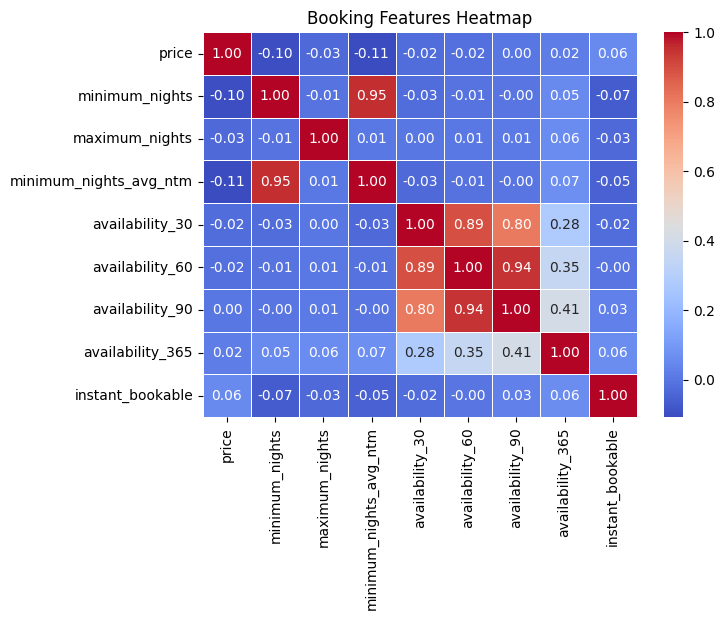

In [ ]:
# heatmap the shit
corr_columns = ['price',
'minimum_nights',
'maximum_nights',
'minimum_nights_avg_ntm',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'instant_bookable']

corr_host = df_cleaned[corr_columns].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_host, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show plot
plt.title("Booking Features Heatmap")
plt.show()

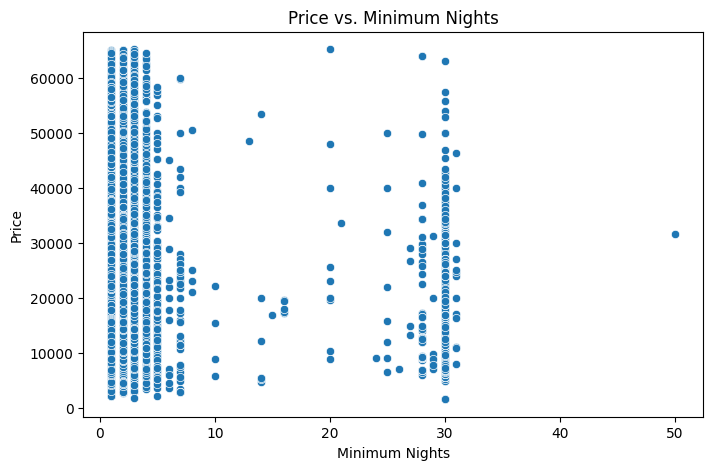

In [ ]:
# Check minimum nights graph against price
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_cleaned["minimum_nights"], y=df_cleaned["price"])
plt.title("Price vs. Minimum Nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Price")
plt.show()


The booking attributes seem to have poor correlated attributes. For now, only the features *avaliabilty_365* and *instant_bookable* seem to be worth looking into.

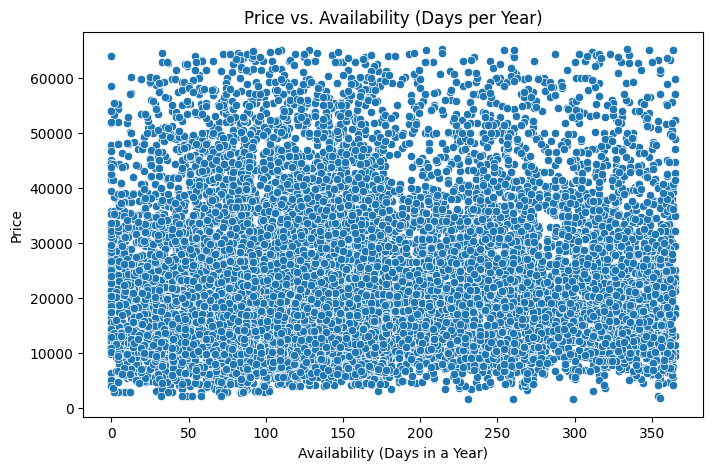

In [ ]:
# analyse availabilty_365
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_cleaned["availability_365"], y=df_cleaned["price"])
plt.title("Price vs. Availability (Days per Year)")
plt.xlabel("Availability (Days in a Year)")
plt.ylabel("Price")
plt.show()


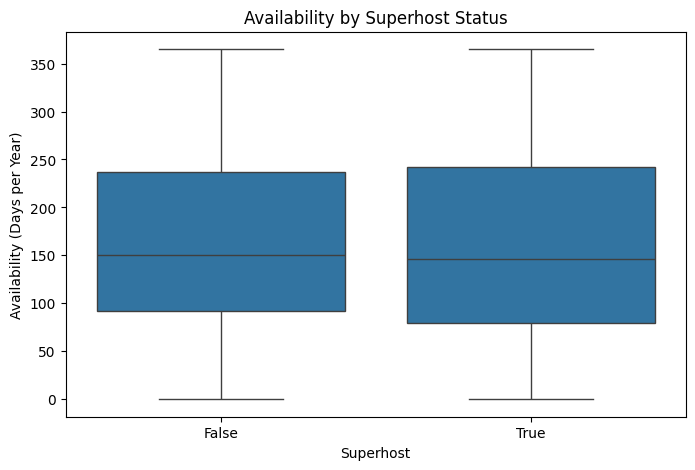

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_cleaned["host_is_superhost"], y=df_cleaned["availability_365"])
plt.title("Availability by Superhost Status")
plt.xlabel("Superhost")
plt.ylabel("Availability (Days per Year)")
plt.show()


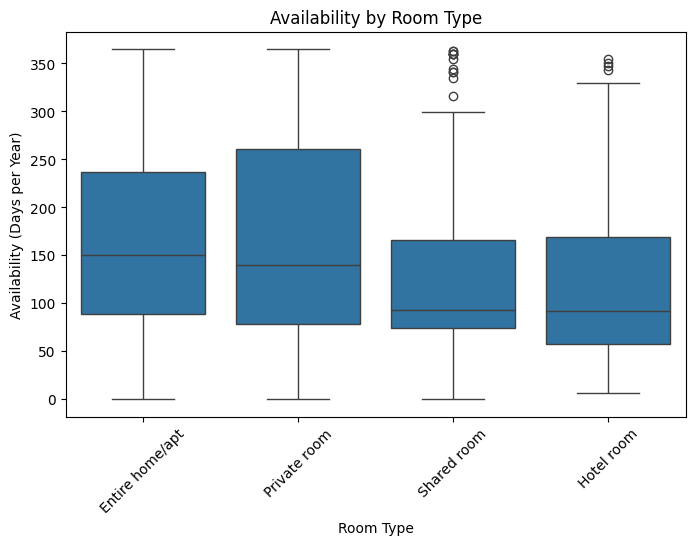

In [ ]:
df_viz = df_cleaned.copy()  # Create a copy to avoid modifying the original data
room_col = ['room_type_Entire home/apt','room_type_Hotel room',	'room_type_Private room',	'room_type_Shared room']

# Convert one-hot encoded columns back to a single categorical column
df_viz["room_type"] = df_viz[room_col].idxmax(axis=1).str.replace("room_type_", "")

# Now plot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_viz["room_type"], y=df_viz["availability_365"])
plt.title("Availability by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Availability (Days per Year)")
plt.xticks(rotation=45)
plt.show()


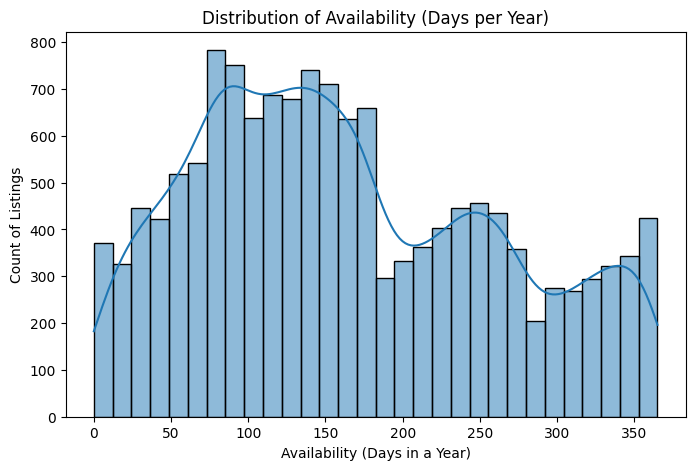

In [ ]:
# See distribution of availabilty
plt.figure(figsize=(8,5))
sns.histplot(df_cleaned["availability_365"], bins=30, kde=True)
plt.title("Distribution of Availability (Days per Year)")
plt.xlabel("Availability (Days in a Year)")
plt.ylabel("Count of Listings")
plt.show()


It is hard to see any kind of relationship here.

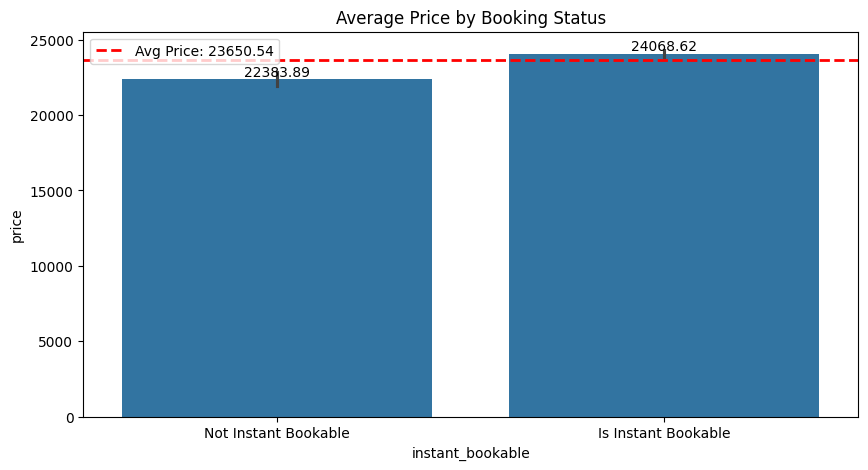

In [ ]:
# Create bar plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="instant_bookable", y="price", data=df_cleaned, estimator=lambda x: x.mean())

# Add a horizontal line for average price
plt.axhline(avg_price, color='red', linestyle='dashed', linewidth=2, label=f'Avg Price: {avg_price:.2f}')

# Annotate each bar with its mean price
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Set proper xticks before setting labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Instant Bookable", "Is Instant Bookable"])

# Add title and legend
plt.title("Average Price by Booking Status")
plt.legend()
plt.show()

## 1.6 Final Findings

Use most of the property/physical attributes, Host attributes maybe, reviews are not so good, Booking attributes only use some. fuck the location anyone want do that have fun lazy

WIP, do later

In [ ]:
print(df_cleaned.columns)
# drop the following
drop_list = ['minimum_nights',
'maximum_nights',
"minimum_minimum_nights",
"maximum_minimum_nights",
"minimum_maximum_nights",
"maximum_maximum_nights",
'minimum_nights_avg_ntm',
'availability_30',
'availability_60',
'availability_90',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value',
'amenities',
'neighbourhood_cleansed',
'longitude',
'latitude']
df_cleaned = df_cleaned.drop(columns=drop_list)
df_cleaned_no_outliers = df_cleaned_no_outliers.drop(columns=drop_list)

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'has_wifi', 'has_kitchen', 'has_pool', 'has_air_conditioning',
       'has_security', 'has_laundry', 'has_bathroom', 'has_entertainment',
       'has_fitness', 'has_child_friendly', '

In [ ]:
print(df_cleaned.columns)
df_cleaned.head(3)

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'reviews_per_month', 'has_wifi', 'has_kitchen', 'has_pool',
       'has_air_conditioning', 'has_security', 'has_laundry', 'has_bathroom',
       'has_entertainment', 'has_fitness', 'has_child_friendly', 'has_outdoor',
       'has_elevator', 'has_ethernet_connection', 'has_refrigerator',
       'has_bbq_grill', 'has_microwave', 'has_stove', 'has_coffee_maker',
       'has_oven', 'has_dining_table', 'has_ev_charger', 'has_hot_tub',
       'has_ceiling_fan', 'has_heating', 'has_carbon_monoxide_alarm',
       'has_fire_extinguisher', 'has_smoke_alarm', 'has_dryer', 'has_washer',
       'has_iron', 'has_clothing_storage', 'has_hot_water', 'has_conditioner',
       'has_shampoo', 'has_bidet', 'has_bathtu

host_response_time  host_response_rate  host_acceptance_rate  \
0                   1                 1.0                  0.93   
1                   3                 1.0                  1.00   
2                   3                 1.0                  1.00   

   host_is_superhost  host_identity_verified  accommodates  bathrooms  \
0               True                    True             2        1.0   
1               True                    True             1        1.0   
2               True                   False             6        1.5   

   bedrooms  beds    price  ...  has_exercise_equipment  \
0       1.0   2.0  13000.0  ...                   False   
1       1.0   1.0   9474.0  ...                   False   
2       2.0   4.0  39363.0  ...                   False   

   has_children’s_books_and_toys  has_crib  has_high_chair  has_baby_bath  \
0                          False     False           False          False   
1                          False     False           False          False   
2                          False     False           False          False   

   has_backyard  room_type_Entire home/apt  room_type_Hotel room  \
0         False                       True                 False   
1         False                      False                 False   
2         False                       True                 False   

   room_type_Private room  room_type_Shared room  
0                   False                  False  
1                    True                  False  
2                   False                  False  

[3 rows x 65 columns]

# 2. Data Fitting

Place the relevant factors to be used for training and testing model

To be done

## **SVM**

In [ ]:
#SVM testing

In [ ]:
#Check DataFrame's dtypes before scaling
print(df_cleaned.dtypes)


host_response_time             int64
host_response_rate           float64
host_acceptance_rate         float64
host_is_superhost               bool
host_identity_verified          bool
                              ...   
has_backyard                    bool
room_type_Entire home/apt       bool
room_type_Hotel room            bool
room_type_Private room          bool
room_type_Shared room           bool
Length: 65, dtype: object


In [ ]:
# =============================================================================
# 1. Data Preparation
# =============================================================================
# Assume df_cleaned is your preprocessed DataFrame (with relevant columns)
#  - If you have latitude/longitude, keep them or transform them into features
#  - If you have textual data, consider extracting word counts, sentiment, etc.

use_log_target = True  # set True if your target (price) is skewed

if use_log_target:
    y_transformed = np.log1p(df_cleaned['price'])
else:
    y_transformed = df_cleaned['price']

X = df_cleaned.drop(columns=['price'])
X = pd.get_dummies(X, drop_first=True)  # encode categoricals if any remain

X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=42
)

# We'll apply standard scaling, but also do polynomial features on select numeric columns
numeric_cols = ['bathrooms', 'bedrooms', 'beds', 'accommodates']  # Adjust to your dataset
poly = PolynomialFeatures(degree=2, include_bias=False)

# We'll separate out numeric cols to transform them, then rejoin with the rest
X_train_num = X_train[numeric_cols]
X_test_num  = X_test[numeric_cols]

# Polynomial transformation
X_train_poly = poly.fit_transform(X_train_num)
X_test_poly  = poly.transform(X_test_num)

# Build new DataFrames with polynomial columns
poly_feature_names = poly.get_feature_names_out(numeric_cols)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
X_test_poly_df  = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test.index)

# Drop the original numeric columns from X_train, X_test
X_train_rest = X_train.drop(columns=numeric_cols)
X_test_rest  = X_test.drop(columns=numeric_cols)

# Concatenate the polynomial numeric columns with the rest
X_train_final = pd.concat([X_train_rest, X_train_poly_df], axis=1)
X_test_final  = pd.concat([X_test_rest,  X_test_poly_df], axis=1)

# Now apply standard scaling to the final sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled  = scaler.transform(X_test_final)

# Helper function to revert target predictions if we used log transform
def revert_target(y):
    return np.expm1(y) if use_log_target else y

# 3. Model Training

To be done

## **SVM**

In [ ]:
# =============================================================================
# 2. Baseline SVM (Linear) with Polynomial Features
# =============================================================================
svm_baseline = SVR(kernel='linear', C=1.0)
svm_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = svm_baseline.predict(X_test_scaled)

baseline_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_baseline))
baseline_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_baseline)))
baseline_r2 = r2_score(revert_target(y_test), revert_target(y_pred_baseline))

print("Baseline SVM (Linear + PolyFeatures) Performance:")
print(f"MAE: {baseline_mae:.2f}")
print(f"RMSE: {baseline_rmse:.2f}")
print(f"R²: {baseline_r2:.4f}")

Baseline SVM (Linear + PolyFeatures) Performance:
MAE: 6987.01
RMSE: 9681.41
R²: 0.4307


## **Bayesian tuning**

In [ ]:
# =============================================================================
# 3. Tuning Models
# =============================================================================
# ---------------------------
# 3.1 Bayesian Tuning for SVM (Linear)
# ---------------------------
bayes_search_params = {
    'C': Real(0.1, 10.0, prior='log-uniform'),
    'epsilon': Real(0.01, 1.0, prior='log-uniform')
}

svr_linear = SVR(kernel='linear')
bayes_search = BayesSearchCV(
    estimator=svr_linear,
    search_spaces=bayes_search_params,
    n_iter=10,
    cv=2,  # Reduced folds for speed
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
bayes_search.fit(X_train_scaled, y_train)
best_bayes_svr = bayes_search.best_estimator_
y_pred_bayes = best_bayes_svr.predict(X_test_scaled)

bayes_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_bayes))
bayes_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_bayes)))
bayes_r2 = r2_score(revert_target(y_test), revert_target(y_pred_bayes))

print("\nBayesian Tuned SVM Performance:")
print(f"MAE: {bayes_mae:.2f}")
print(f"RMSE: {bayes_rmse:.2f}")
print(f"R²: {bayes_r2:.4f}")

plt.figure(figsize=(8,5))
sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_bayes), alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Bayesian Tuned SVM: Actual vs. Predicted")
plt.show()

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


## **Tuning SVM with Randomized search**

*   List item
*   List item



In [ ]:
# =============================================================================
# 4. Extended XGBoost Tuning with Polynomial Features
# =============================================================================
xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

xgb_model = XGBRegressor(random_state=42)
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=12,   # Adjust for your computational budget
    cv=3,        # Increase folds for better estimates
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_search.fit(X_train_scaled, y_train)
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

xgb_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_xgb))
xgb_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_xgb)))
xgb_r2 = r2_score(revert_target(y_test), revert_target(y_pred_xgb))

print("\nTuned XGBoost (PolyFeatures) Performance:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R²: {xgb_r2:.4f}")


##**SVM + XGBoost Blending**

In [ ]:
# =============================================================================
# 5. Blending: SVM + XGBoost
# =============================================================================
y_pred_svr_blend = best_bayes_svr.predict(X_test_scaled)
y_pred_xgb_blend = best_xgb.predict(X_test_scaled)

svm_weight_candidates = [0.1, 0.3, 0.5, 0.7, 0.9]
best_weight = None
best_blend_r2 = -np.inf
for w in svm_weight_candidates:
    blend_pred = w * y_pred_svr_blend + (1 - w) * y_pred_xgb_blend
    r2_temp = r2_score(revert_target(y_test), revert_target(blend_pred))
    if r2_temp > best_blend_r2:
        best_blend_r2 = r2_temp
        best_weight = w

y_pred_blended_opt = best_weight * y_pred_svr_blend + (1 - best_weight) * y_pred_xgb_blend
blend_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_blended_opt))
blend_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_blended_opt)))
blend_r2 = r2_score(revert_target(y_test), revert_target(y_pred_blended_opt))

print("\nOptimized Blended Model (SVM + XGBoost) with PolyFeatures:")
print(f"Best Blending Weight (SVM): {best_weight:.2f}")
print(f"MAE: {blend_mae:.2f}")
print(f"RMSE: {blend_rmse:.2f}")
print(f"R²: {blend_r2:.4f}")

In [ ]:
# =============================================================================
# 6. Stacking with More Models (Including RandomForest)
# =============================================================================
from sklearn.linear_model import Ridge

estimators = [
    ('svm', best_bayes_svr),
    ('xgb', best_xgb),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42))
    # Optionally add CatBoost if installed:
    # ('cat', CatBoostRegressor(verbose=0, random_state=42))
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=3,
    n_jobs=-1
)
stack_reg.fit(X_train_scaled, y_train)
y_pred_stack = stack_reg.predict(X_test_scaled)

stack_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_stack))
stack_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_stack)))
stack_r2 = r2_score(revert_target(y_test), revert_target(y_pred_stack))

print("\nStacking Regressor (SVM + XGB + RF + PolyFeatures) Performance:")
print(f"MAE: {stack_mae:.2f}")
print(f"RMSE: {stack_rmse:.2f}")
print(f"R²: {stack_r2:.4f}")



Stacking Regressor (SVM + XGB + RF + PolyFeatures) Performance:
MAE: 6114.02
RMSE: 8698.80
R²: 0.5404


##**Stacking Regressor**






Stacking Regressor Performance:
MAE: 6135.52
RMSE: 8715.65
R²: 0.5386


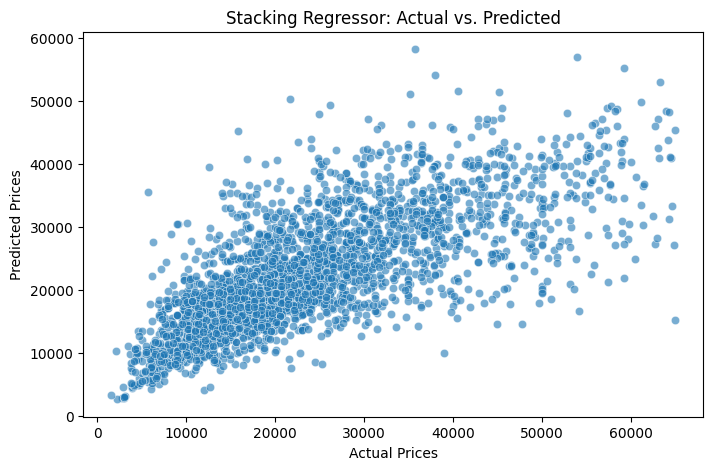

In [ ]:
# =============================================================================
# 5. Advanced Stacking Ensemble
# =============================================================================
# Create a stacking regressor with diverse models.
estimators = [
    ('svm', SVR(kernel='linear', C=best_bayes_svr.get_params()['C'], epsilon=best_bayes_svr.get_params()['epsilon'])),
    ('xgb', best_xgb),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
]

# Use a Ridge regressor as the final estimator (meta-learner)
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=2,
    n_jobs=-1
)
stack_reg.fit(X_train_scaled, y_train)
y_pred_stack = stack_reg.predict(X_test_scaled)

stack_mae = mean_absolute_error(revert_target(y_test), revert_target(y_pred_stack))
stack_rmse = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_stack)))
stack_r2 = r2_score(revert_target(y_test), revert_target(y_pred_stack))

print("\nStacking Regressor Performance:")
print(f"MAE: {stack_mae:.2f}")
print(f"RMSE: {stack_rmse:.2f}")
print(f"R²: {stack_r2:.4f}")

plt.figure(figsize=(8,5))
sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_stack), alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Stacking Regressor: Actual vs. Predicted")
plt.show()

In [ ]:
# =============================================================================
# 7. Summary of Results
# =============================================================================
print("\n--- Analysis and Findings ---")
print("| Model                                        |   MAE   |   RMSE   |  R² Score |")
print("|----------------------------------------------|---------|----------|-----------|")
print("| Baseline SVM (Linear + Poly)                 | {:.2f} | {:.2f} | {:.4f} |".format(
    baseline_mae, baseline_rmse, baseline_r2))
print("| Bayesian Tuned SVM (Linear + Poly)           | {:.2f} | {:.2f} | {:.4f} |".format(
    bayes_mae, bayes_rmse, bayes_r2))
print("| Tuned XGBoost (Poly)                         | {:.2f} | {:.2f} | {:.4f} |".format(
    xgb_mae, xgb_rmse, xgb_r2))
print("| Blended (Optimized Weight) (SVM + XGB + Poly)| {:.2f} | {:.2f} | {:.4f} |".format(
    blend_mae, blend_rmse, blend_r2))
print("| Stacking (SVM + XGB + RF + Poly)             | {:.2f} | {:.2f} | {:.4f} |".format(
    stack_mae, stack_rmse, stack_r2))



--- Analysis and Findings ---
| Model                                        |   MAE   |   RMSE   |  R² Score |
|----------------------------------------------|---------|----------|-----------|
| Baseline SVM (Linear + Poly)                 | 6987.01 | 9681.41 | 0.4307 |
| Bayesian Tuned SVM (Linear + Poly)           | 6992.54 | 9664.36 | 0.4327 |
| Tuned XGBoost (Poly)                         | 6090.46 | 8699.45 | 0.5403 |
| Blended (Optimized Weight) (SVM + XGB + Poly)| 6109.27 | 8699.82 | 0.5403 |
| Stacking (SVM + XGB + RF + Poly)             | 6135.52 | 8715.65 | 0.5386 |


# 4. Analysis and Findings

SVM  results (Japan dataset)


---



| Model | MAE ↓ (Lower is better) | RMSE ↓ (Lower is better) | R² Score ↑ (Higher is better) |
|---|---|---|---|
| Original SVM (Linear Kernel) | 9758.10 | 16079.02 | 0.286 |
| Tuned SVM (Randomized Search) | 9063.57 | 15018.86 | 0.377 |
| Previous Blended (SVM 10% + XGBoost 90%) | 8441.13 | 13252.65 | 0.5151 |
| **Optimized Blended (SVM 5% + XGBoost 95%)** | **8452.77** | **13209.68** | **0.5182** |



📊 SVM Kernel Comparison Results (London Dataset):

| Kernel | MAE | MSE | RMSE | R² Score |
|---|---|---|---|---|
| **linear** | **41.718353** | **3641.735994** | **60.346798** | **0.534499** |
| **poly** | **65.945551** | **7742.455150** | **87.991222** | **0.010329** |
| **rbf** | **65.718446** | **7740.682362** | **87.981148** | **0.010556** |
| **sigmoid** | **602.023364** | **466483.108752** | **682.995687** | **-58.627682** |

Can just focus on linear function, other functions are completely dogshit and takes too long




Might need to use other models to get better results, the result had a improvement with blending/tuning but still lacklusture
